# TRABAJO DE FIN DE MÁSTER: Estudio de modelos de Aprendizaje Automático para la predicción de valores en el mercado financiero

Autor -- JESÚS ORTIZ PÉREZ

v1.0

Librerías generales / Standard libraries

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import ta
import os
import logging
import mplfinance as mpf

Librerías de Machine / Deep Learning | Machine / Deep Learning libraries

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l2
from keras_tuner import RandomSearch

In [3]:
# Random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42

# logging configuration
logging.basicConfig(level=logging.INFO)

Funciones de Adquisición de datos | Data adquisition functions

In [26]:
# Function to download stock data with error handling
def download_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        logging.info(f"Data fetched for {ticker}")
        return data
    except Exception as e:
        logging.error(f"Failed to fetch data for {ticker}: {e}")
        return None

# Load and cache data for multiple stocks
def load_stock_data(stocks, company_names, start, end):
    all_data = []
    for stock, name in zip(stocks, company_names):
        cache_path = f'cache/{stock}.pkl'
        if os.path.exists(cache_path):
            data = pd.read_pickle(cache_path)
            logging.info(f"Loaded {stock} from cache.")
        else:
            data = download_stock_data(stock, start, end)
            if data is not None:
                os.makedirs('cache', exist_ok=True)
                data.to_pickle(cache_path)

        if data is not None:
            data['company_name'] = name
            all_data.append(data)

    return pd.concat(all_data, axis=0)

# Function to calculate financial indicators
def calculate_financial_indicators(df, groupby_field='company_name'):
    price_columns = ['Adj Close', 'Open', 'Close', 'High', 'Low']
    df = df.copy()

    for column in price_columns:
        df[f'{column}_Daily Return'] = df.groupby(groupby_field)[column].pct_change()
        df[f'{column}_Log Returns'] = df.groupby(groupby_field)[column].transform(lambda x: np.log(x / x.shift(1)))
        #df[f'{column}_Rolling Volatility'] = df.groupby(groupby_field)[f'{column}_Log Returns'].transform(
        #   lambda x: x.rolling(window=20, min_periods=20).std() * np.sqrt(252))  # volatility with log returns

        # Calculate rolling volatility using daily returns (annualized)
        df[f'{column}_Rolling Volatility'] = df.groupby(groupby_field)[f'{column}_Daily Return'].transform(
            lambda x: x.rolling(window=20, min_periods=20).std() * np.sqrt(252))

        for window in [10, 20, 50]:
            df[f'{column}_SMA_{window}'] = df.groupby(groupby_field)[column].transform(
                lambda x: x.rolling(window=window, min_periods=window).mean())

        df[f'{column}_RSI'] = df.groupby(groupby_field)[column].transform(
            lambda x: ta.momentum.rsi(x, window=14, fillna=False))
        df[f'{column}_MACD'] = df.groupby(groupby_field)[column].transform(
            lambda x: ta.trend.macd(x, fillna=False))

    df.dropna(inplace=True)

    return df


Funciones de Análisis Exploratorio de Datos | Exploratory Data Analysis functions

In [27]:
def plot_japan_candlesticks(main_df, company_names, start_date=None, end_date=None):
    """
    Plot Japan candlestick charts for multiple stocks, including volume, with smaller font sizes and larger figure size.

    :param main_df: DataFrame containing stock data with columns: Open, High, Low, Close, Volume.
    :param company_names: List of company names to plot.
    :param start_date: Start date for filtering the data (optional).
    :param end_date: End date for filtering the data (optional).
    """

    plt.rc('font', size=10, weight='normal') 

    for company in company_names:
        # Filter data for each company
        company_data = main_df[main_df['company_name'] == company].copy()

        if start_date:
            company_data = company_data[company_data.index >= start_date]
        if end_date:
            company_data = company_data[company_data.index <= end_date]

        # Select only required columns for mplfinance (Open, High, Low, Close, Volume)
        company_data = company_data[['Open', 'High', 'Low', 'Close', 'Volume']]

        # Plot candlestick and volume directly using mplfinance
        mpf.plot(
            company_data,
            type='candle',
            volume=True,
            style='charles',
            title=f'{company} - Candlestick & Volume',
            figsize=(18, 10)  
        )

def plot_rolling_volatility(df, groupby_field='company_name', column='Adj Close', window=20):
    """
    Plot the rolling volatility for each stock in separate subplots (2 columns).

    :param df: DataFrame containing the stock data with rolling volatility calculated
    :param groupby_field: Column to group by (e.g., company name)
    :param column: Price column to plot the volatility for (default is 'Adj Close')
    :param window: The window used to calculate the rolling volatility (default is 20)
    """
    companies = df[groupby_field].unique()
    num_companies = len(companies)

    rows = (num_companies + 1) // 2  # This ensures an integer number of rows


    fig, axes = plt.subplots(rows, 2, figsize=(14, 5 * rows))
    axes = axes.flatten()  

    for i, company in enumerate(companies):
        company_data = df[df[groupby_field] == company]
        axes[i].plot(company_data.index, company_data[f'{column}_Rolling Volatility']*100, label=f'{company} Volatility')
        axes[i].set_title(f'{company} - Volatilidad cada {window} días')
        axes[i].set_xlabel('Fecha')
        axes[i].set_ylabel('Volatilidad')
        axes[i].grid(True)

    for i in range(num_companies, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

Funciones de procesado y configuración de modelos de Machine Learning | Data proccessing and Machine Learning model configuration functions

In [28]:
# Function to create ML datasets
def create_ML_dataset(data, lookback, target_column, mode):
    dataX, dataY, dates = [], [], []

    if mode == 'core_values':
        features = data.drop(columns=[target_column]).values
    else:
        features = data.values

    target = data[target_column].values

    for i in range(len(data) - lookback):
        window = features[i:i + lookback]
        dataX.append(window)
        dataY.append(target[i + lookback])
        dates.append(data.index[i + lookback])

    return np.array(dataX), np.array(dataY), np.array(dates)

# Function to prepare data for modeling
def prepare_data_for_modeling(main_df, company_name, target_value, mode, specific_indicators=None):
    company_data = main_df[main_df['company_name'] == company_name]

    if mode == 'without_indicators':
        columns = [target_value]
    elif mode == 'specific_indicators':
        if specific_indicators is None:
            raise ValueError("Please provide a list of specific indicators to include.")
        columns = [target_value] + [f"{target_value}_{indicator}" for indicator in specific_indicators]
        columns = [col for col in columns if col in company_data.columns]
    elif mode == 'all_indicators':
        columns = [col for col in company_data.columns if col.startswith(target_value)]
    elif mode == 'core_values':
        core_columns = ['Open', 'Close', 'High', 'Low', 'Adj Close']
        columns = [target_value] + [col for col in core_columns if col != target_value and col in company_data.columns]
    else:
        raise ValueError("Invalid mode selected. Choose from 'without_indicators', 'specific_indicators', 'all_indicators', 'core_values'.")

    target_specific_df = company_data[columns].copy()
    return target_specific_df

# Function to select model and parameters
def get_model_and_params(model_choice):
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200, 500],  # Reduced number of trees
            'max_depth': [10, 15, 20],  # Reduced tree depth
            'min_samples_split': [2, 5],  # Kept split options
            'min_samples_leaf': [1, 2, 4],  # Reduced options
            'max_features': ['sqrt', 'log2'],  # Simplified
            'bootstrap': [True, False]  # Kept both options
        },


        'Linear Regression': {
            'fit_intercept': [True, False],  # Keeping these as they are relevant
            'positive': [True, False]
        },

        'Decision Tree': {
            'max_depth': [5, 10, 15, 20, 25, 30, None],  # Added deeper values for more flexibility
            'min_samples_split': [2, 5, 10, 15],  # Reduced upper range to focus on smaller splits
            'min_samples_leaf': [1, 2, 4],  # Removed larger values
            'max_features': ['auto', 'sqrt', 'log2'],  # Removed 'None' for simplification
            'splitter': ['best', 'random']
        },

        'SVR': {
            'kernel': ['linear', 'rbf', 'sigmoid'],  # Kept commonly used kernels
            'C': [0.1, 1, 10, 100, 1000],  # Expanded upper range for stronger regularization
            'epsilon': [0.01, 0.1, 0.2, 0.5],  # Added 0.5 for more tolerance to errors
            'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Added lower values for more control
            # Removed 'degree' since 'poly' kernel is not being used
        },

        'Gradient Boosting': {
          'n_estimators': [100, 200],  # 100 and 200 for fewer estimators, as diminishing returns occur at higher values
          'learning_rate': [0.01, 0.1],  # 0.01 and 0.1 are commonly used values
          'max_depth': [3, 5],  # 3 and 5, deeper trees can lead to overfitting
          'min_samples_split': [2, 5],  # common values for reliable performance
          'min_samples_leaf': [1, 2],  # large values can lead to underfitting
          'subsample': [0.8, 1.0],  # Subsampling at 80% and 100% for more control over regularization
          'max_features': ['sqrt', 'log2']
        }
    }


    if model_choice == 'Linear Regression':
        model = LinearRegression()
        param_grid = param_grids['Linear Regression']
    elif model_choice == 'Decision Tree':
        model = DecisionTreeRegressor(random_state=random_state)
        param_grid = param_grids['Decision Tree']
    elif model_choice == 'Random Forest':
        model = RandomForestRegressor(random_state=random_state)
        param_grid = param_grids['Random Forest']
    elif model_choice == 'SVR':
        model = SVR()
        param_grid = param_grids['SVR']
    elif model_choice == 'Gradient Boosting':
        model = GradientBoostingRegressor(random_state=random_state)
        param_grid = param_grids['Gradient Boosting']
    else:
        raise ValueError("Invalid model choice. Choose from 'Linear Regression', 'Decision Tree', 'Random Forest', 'SVR', 'Gradient Boosting'.")

    return model, param_grid

# Function to fit the model using grid or randomized search
def fit_model(X_train, y_train, model, param_grid, use_randomized_search):
    if use_randomized_search:
        search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    else:
        search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    return best_model, search.best_params_

# Function to plot results using subplots
def plot_results_subplots(dates_test, y_test_rescaled, y_pred, target_column, company_name, plot_type, ax):
    ax.plot(dates_test, y_test_rescaled, label='Reales', color='blue')
    ax.plot(dates_test, y_pred, label='Predichos', color='red')
    ax.set_title(f'{target_column} - {company_name} ({plot_type})')
    ax.set_xlabel('Fecha')
    ax.set_ylabel(f'{target_column} Precio ($)')
    ax.legend()

def recursive_forecasting_multi_feature_corrected(
    X_test_scaled, scaler_y, best_model, lookback, forecast_horizon,
    y_test_rescaled, dates_test, target_column, company_name, ax
):
    """
    Perform recursive forecasting with multiple features.
    """
    # num_features should represent the number of original features, not num_features * lookback
    num_features = X_test_scaled.shape[1] // lookback
    predictions = []

    # Initialize current_batch with the last row of X_test_scaled
    current_batch = X_test_scaled[-(forecast_horizon + 1)].copy()  # Shape: (lookback * features,)

    for _ in range(forecast_horizon):
        # Use current_batch directly for prediction
        input_batch = current_batch.reshape(1, -1)  # Shape: (1, num_features * lookback)
        predicted_value = best_model.predict(input_batch)

        # Append prediction to predictions list
        predictions.append(predicted_value[0])

        # Update current_batch
        # Shift left by removing the oldest data and add the predicted value at the end
        # Only shift the last segment of features representing the last timestep
        new_row = np.roll(current_batch, -num_features)  # Shift by number of features
        # Assuming the target feature is the last in the num_features set
        #new_row[-num_features:] = current_batch[-num_features:]  # Maintain previous values for features except the target
        new_row[-num_features] = predicted_value[0]  # Insert the new prediction for the target feature

        current_batch = new_row  # Update current batch

    # Inverse transform the predictions to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(predictions).flatten()

    mse = mean_squared_error(y_test_rescaled[-forecast_horizon:], predictions_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_rescaled[-forecast_horizon:], predictions_original)
    r2 = r2_score(y_test_rescaled[-forecast_horizon:], predictions_original)

    # Plotting results
    ax.plot(dates_test[-forecast_horizon:], y_test_rescaled[-forecast_horizon:], label='Reales', color='blue')
    ax.plot(dates_test[-forecast_horizon:], predictions_original, label='Predichos', color='red')
    ax.set_title(f'{target_column} - {company_name} (predicción de {forecast_horizon} días)')
    ax.set_xlabel('Fecha')
    ax.set_ylabel(f'{target_column} Precio ($)')
    ax.legend()

    return mse,rmse,mae,r2

Configuración general del proyecto | General project configuration

In [29]:
CONFIG = {
    'stocks': ['AAPL', '^GSPC', 'GC=F', 'BTC-USD', 'NVDA'],
    'company_names': ["APPLE", "S&P 500", "GOLD", "BITCOIN", "NVIDIA"],
    'start_date': '2010-01-01',
    'end_date': '2024-06-30',
    'lookback': 20,
    'model_choice': 'Gradient Boosting',  # Choose from 'Linear Regression', 'Decision Tree', 'Random Forest', 'SVR', 'Gradient Boosting'
    'use_randomized_search': True,  # Set to True for RandomizedSearchCV, False for GridSearchCV
    'mode': 'specific_indicators',  # Choose from 'without_indicators', 'specific_indicators', 'all_indicators', 'core_values'
    'specific_indicators': ['Log Return','SMA_10','SMA_50','RSI','MACD'],  # Specify indicators if mode is 'specific_indicators'
    'forecast_horizon': 10  # Number of days to forecast
}

# === Possible modes ===
# 1. 'without_indicators': predict the value with only historical data from this value
# 2. 'specific_indicators': choose which financial indicators you want in the prediction
#                           ['Daily Return', 'Log Return','Rolling Volatility','SMA_10','SMA_20','SMA_50','RSI','MACD']
# 3. 'all_indicators': use the target value with all the financial indicators in the prediction
# 4. 'core_values': use the other values of the Japan Candlestick for the prediction

Creación del dataframe con todos los datos | Dataframe creation with all data 

In [30]:
stocks_data_df = load_stock_data(CONFIG['stocks'], CONFIG['company_names'], CONFIG['start_date'], CONFIG['end_date'])
main_df = calculate_financial_indicators(stocks_data_df)


INFO:root:Loaded AAPL from cache.
INFO:root:Loaded ^GSPC from cache.
INFO:root:Loaded GC=F from cache.
INFO:root:Loaded BTC-USD from cache.
INFO:root:Loaded NVDA from cache.


EDA

In [ ]:
plot_japan_candlesticks(main_df, CONFIG['company_names'], start_date=CONFIG['start_date'], end_date=CONFIG['end_date'])

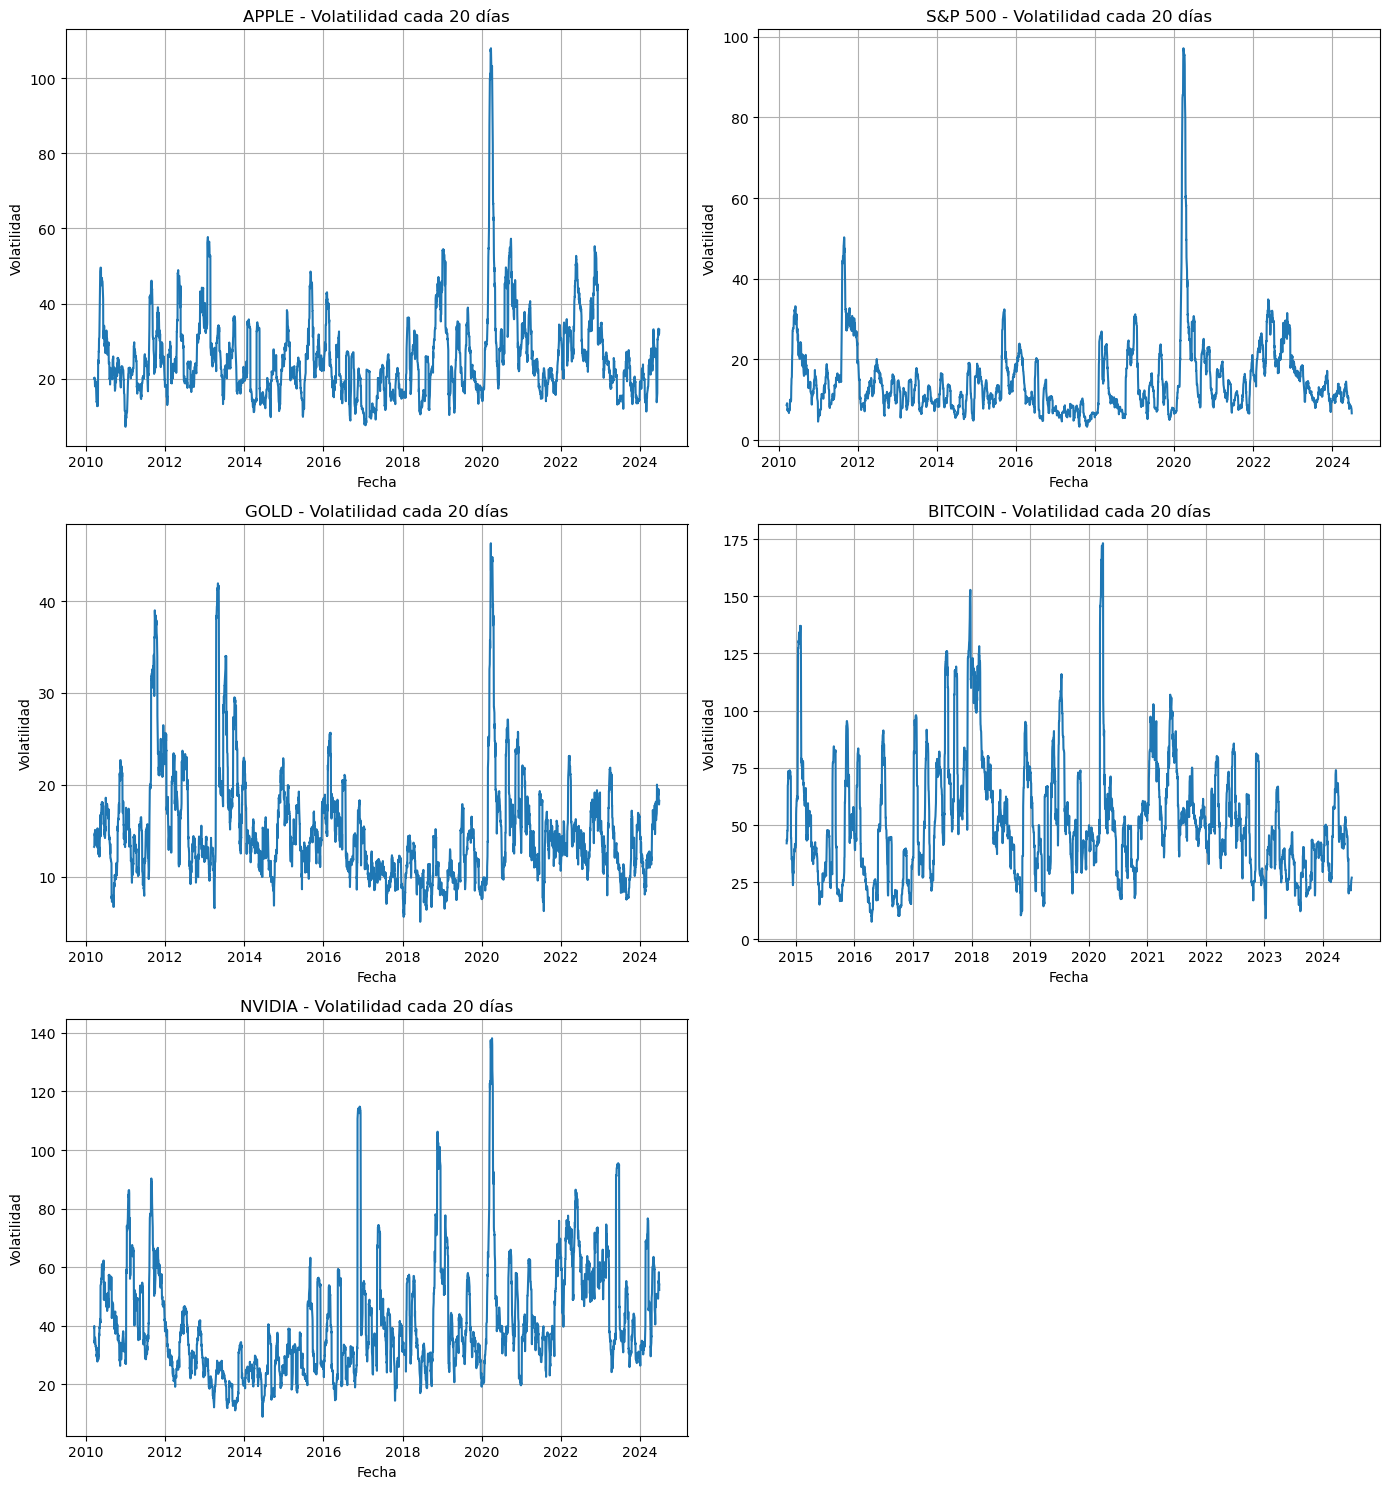

In [ ]:
plot_rolling_volatility(main_df)

Predicción para modelos de Machine Learning | Machine Learning models prediction

INFO:root:Predicting Open for APPLE...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 179.88802480712056, RMSE: 13.412234146745298, MAE: 10.161945709733098, R^2: 0.5514577172691602

INFO:root:Gradient Boosting recursive forecasting - MSE: 1728.294368345037, RMSE: 41.57275993177548, MAE: 41.439455931707, R^2: -203.1254020332278

INFO:root:Predicting Close for APPLE...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 123.35029643466513, RMSE: 11.106317861229487, MAE: 8.026064257122776, R^2: 0.6906550207571536

INFO:root:Gradient Boosting recursive forecasting - MSE: 1320.933121556979, RMSE: 36.344643643279525, MAE: 36.216246867405175, R^2: -158.89420478885367

INFO:root:Predicting High for APPLE...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 208.3172421413512, RMSE: 14.43319930373551, MAE: 11.12385795405731, R^2: 0.47042405284515676

INFO:root:Gradient Boosting recursive forecasting - MSE: 1957.2671013711183, RMSE: 44.241011531961135, MAE: 44.15722064594911, R^2: -329.89433117150304

INFO:root:Predicting Low for APPLE...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 162.27007741117507, RMSE: 12.73852728580408, MAE: 9.602417519916363, R^2: 0.6015211770892019

INFO:root:Gradient Boosting recursive forecasting - MSE: 1565.4696338599517, RMSE: 39.566016148456896, MAE: 39.49189303184296, R^2: -331.16515472114764

INFO:root:Predicting Adj Close for APPLE...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 178.94941699685486, RMSE: 13.3771976511097, MAE: 10.042331657298655, R^2: 0.5652492357080277

INFO:root:Gradient Boosting recursive forecasting - MSE: 1727.1371090975233, RMSE: 41.55883912114874, MAE: 41.43149443063271, R^2: -208.54811716001157



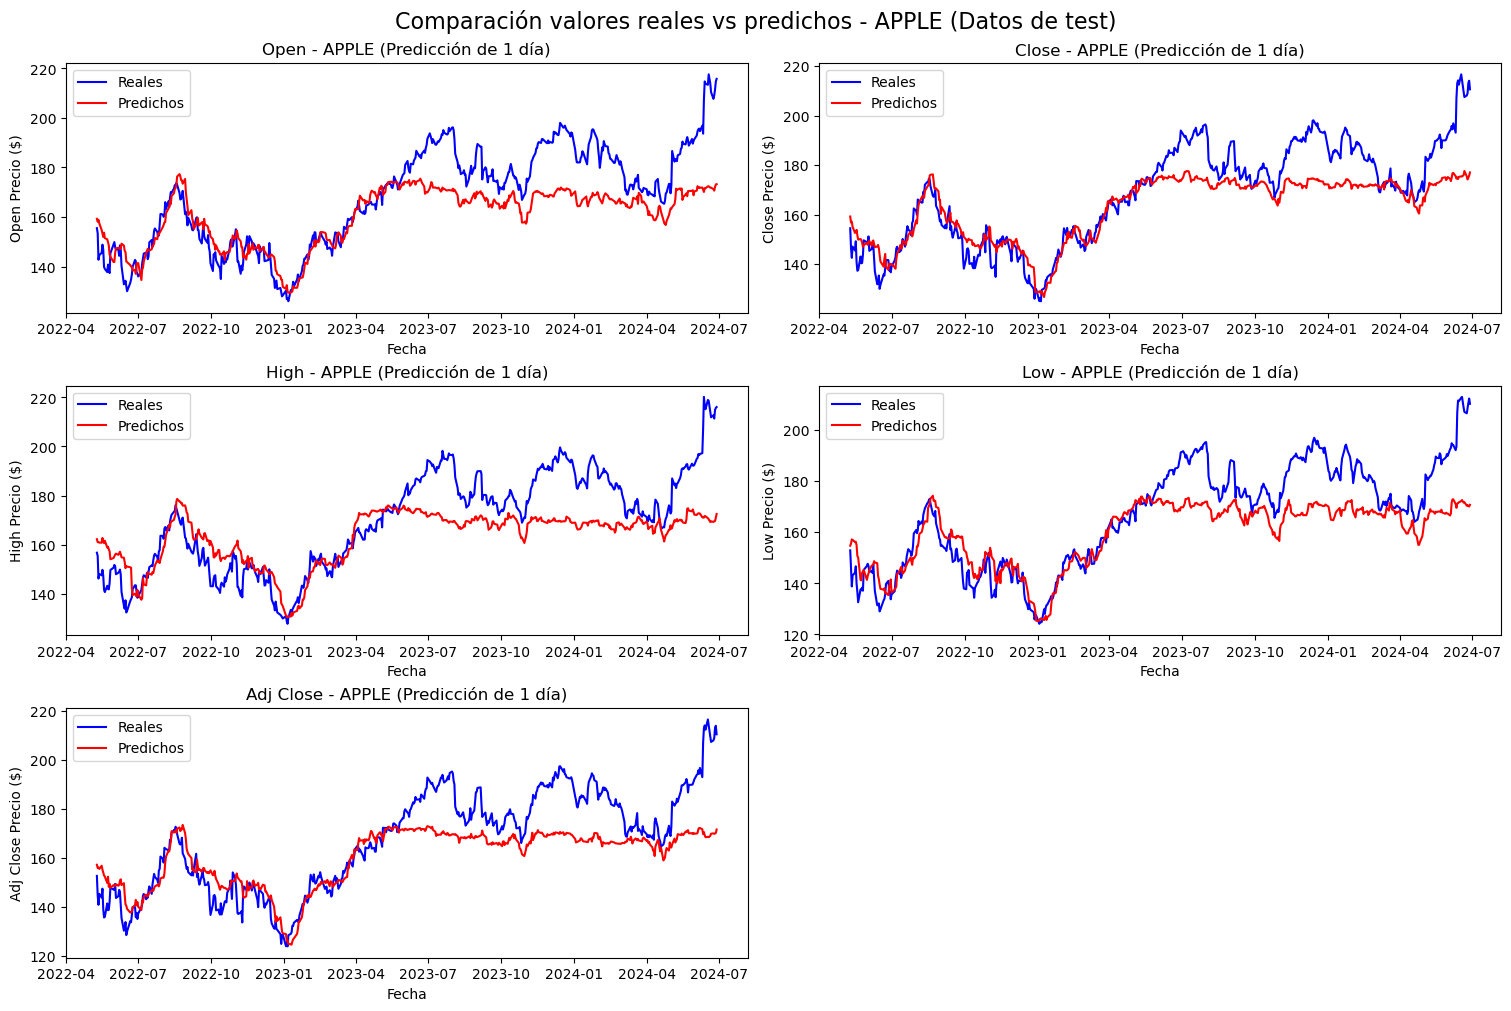

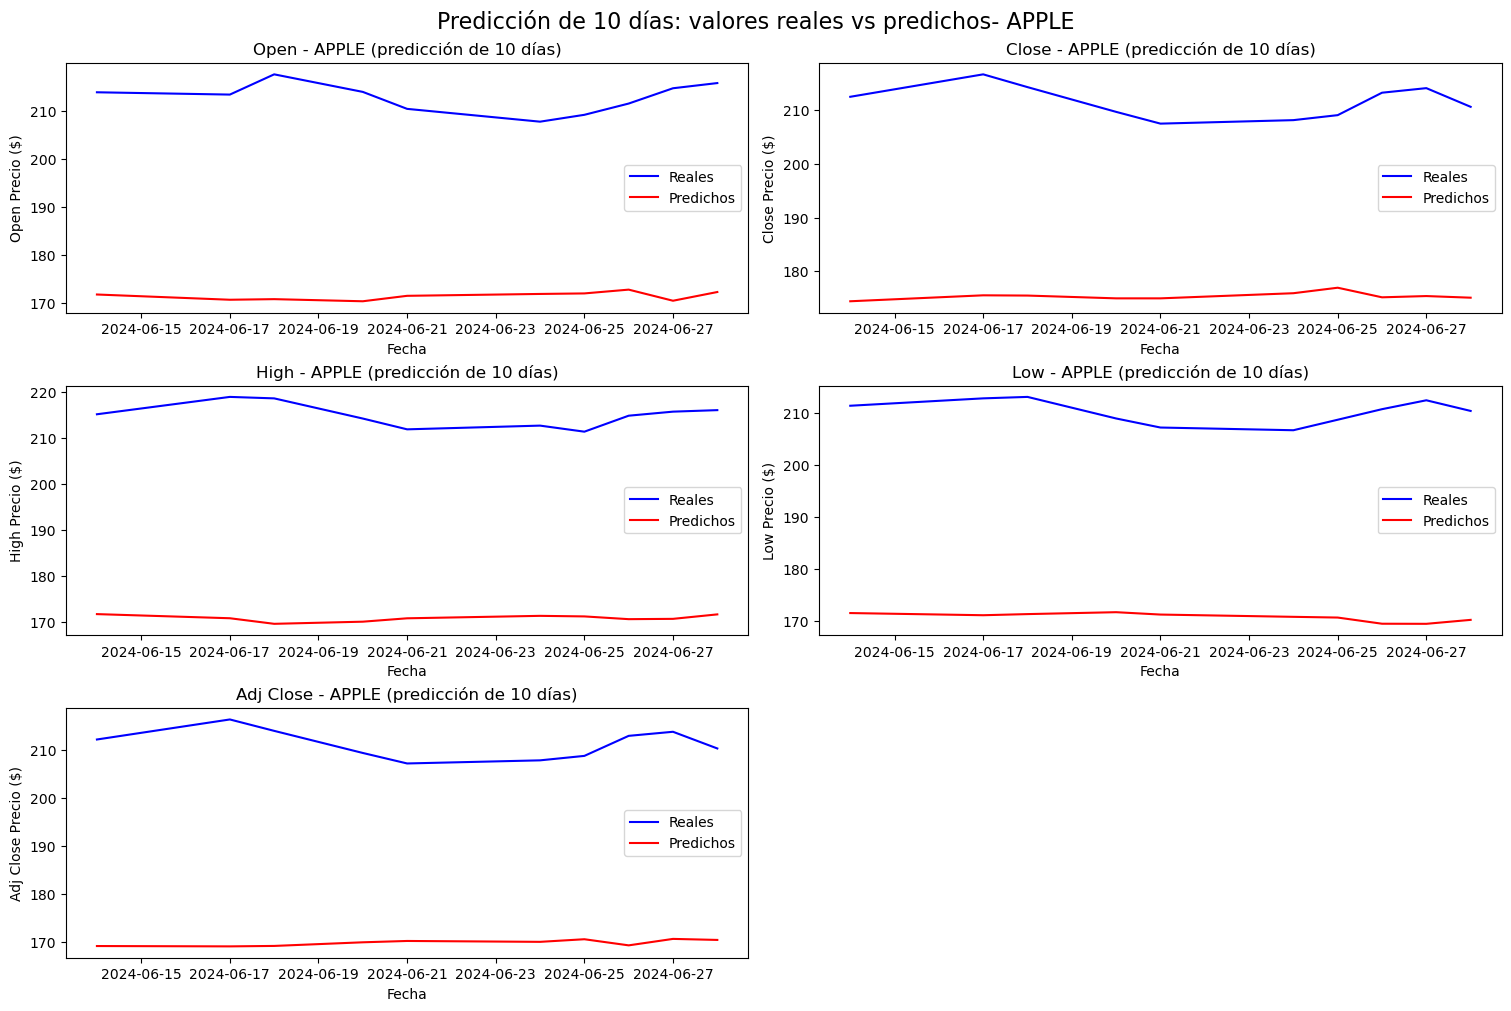

INFO:root:Predicting Open for S&P 500...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 86970.44956924541, RMSE: 294.9075271491818, MAE: 199.7171153355179, R^2: 0.6320782961145059

INFO:root:Gradient Boosting recursive forecasting - MSE: 780750.390933157, RMSE: 883.6008097173502, MAE: 882.8451529025776, R^2: -1606.1114381173384

INFO:root:Predicting Close for S&P 500...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 67851.61973754883, RMSE: 260.4834346701318, MAE: 172.0170572423681, R^2: 0.7133947999966754

INFO:root:Gradient Boosting recursive forecasting - MSE: 678700.1039133568, RMSE: 823.832570315933, MAE: 823.3945887359432, R^2: -2691.252350308359

INFO:root:Predicting High for S&P 500...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 75512.16732020288, RMSE: 274.7947730947641, MAE: 181.84175301003484, R^2: 0.6735718603740518

INFO:root:Gradient Boosting recursive forecasting - MSE: 752274.0269222043, RMSE: 867.3373201483978, MAE: 866.7026821825593, R^2: -1509.4281982573305

INFO:root:Predicting Low for S&P 500...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 93087.97278423434, RMSE: 305.1032166074857, MAE: 199.73798897024798, R^2: 0.6139207541204612

INFO:root:Gradient Boosting recursive forecasting - MSE: 903202.44917782, RMSE: 950.3696381818077, MAE: 949.7405564494329, R^2: -2419.953164141833

INFO:root:Predicting Adj Close for S&P 500...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 89193.82650708158, RMSE: 298.65335509095087, MAE: 198.9561855246205, R^2: 0.6232453317399989

INFO:root:Gradient Boosting recursive forecasting - MSE: 835562.8254165428, RMSE: 914.0912566131145, MAE: 913.862393227961, R^2: -3313.4918758479494



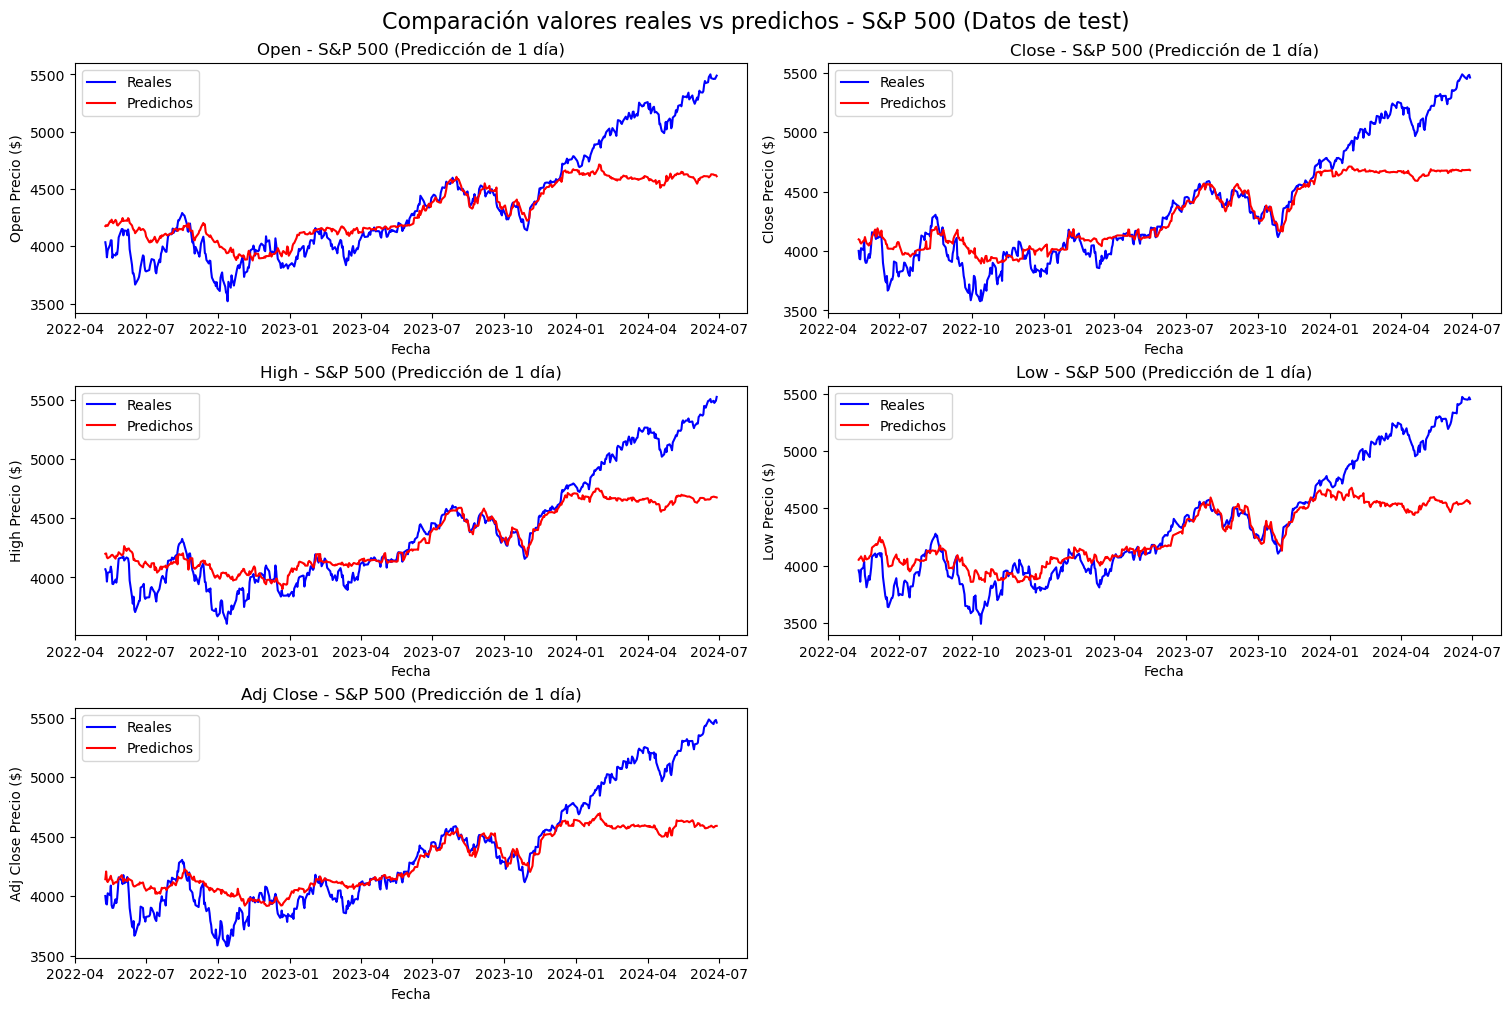

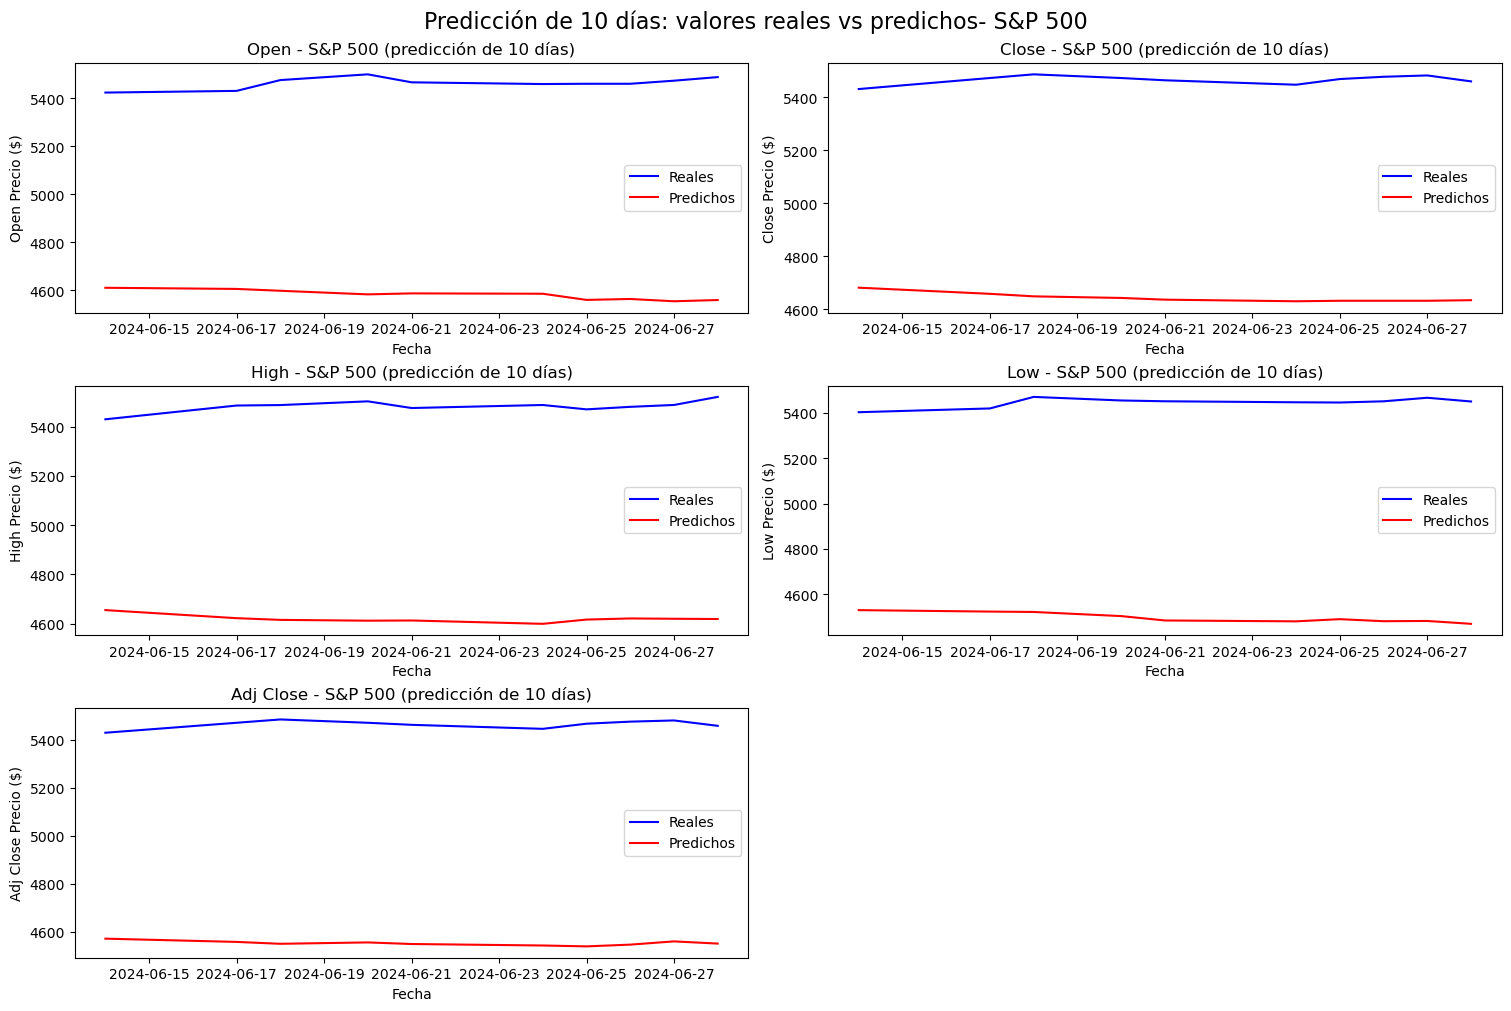

INFO:root:Predicting Open for GOLD...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 20759.59639321977, RMSE: 144.08190862568335, MAE: 79.46435161776684, R^2: 0.40306260038408315

INFO:root:Gradient Boosting recursive forecasting - MSE: 137691.23828649687, RMSE: 371.06770040856003, MAE: 370.900940611946, R^2: -1215.7597032598248

INFO:root:Predicting Close for GOLD...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 20870.883798473653, RMSE: 144.46758736295715, MAE: 80.89386783112892, R^2: 0.4006627876186153

INFO:root:Gradient Boosting recursive forecasting - MSE: 156107.90265168235, RMSE: 395.1049261293541, MAE: 394.4442193386531, R^2: -822.6802854018664

INFO:root:Predicting High for GOLD...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 20445.929064454936, RMSE: 142.98926205997057, MAE: 79.64224623011006, R^2: 0.4221313691231071

INFO:root:Gradient Boosting recursive forecasting - MSE: 138143.32012106472, RMSE: 371.6763647598065, MAE: 371.28124136267735, R^2: -1402.38055733018

INFO:root:Predicting Low for GOLD...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 23147.150621399003, RMSE: 152.14187661981498, MAE: 87.93182624980504, R^2: 0.323816649930347

INFO:root:Gradient Boosting recursive forecasting - MSE: 158712.11477655114, RMSE: 398.38689081915226, MAE: 398.27971843847786, R^2: -1589.4366240836746

INFO:root:Predicting Adj Close for GOLD...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 18905.35829593018, RMSE: 137.49675740151176, MAE: 75.48806623017077, R^2: 0.4571056573568425

INFO:root:Gradient Boosting recursive forecasting - MSE: 132455.56370775588, RMSE: 363.94445140399637, MAE: 363.4417804824649, R^2: -697.8822132938552



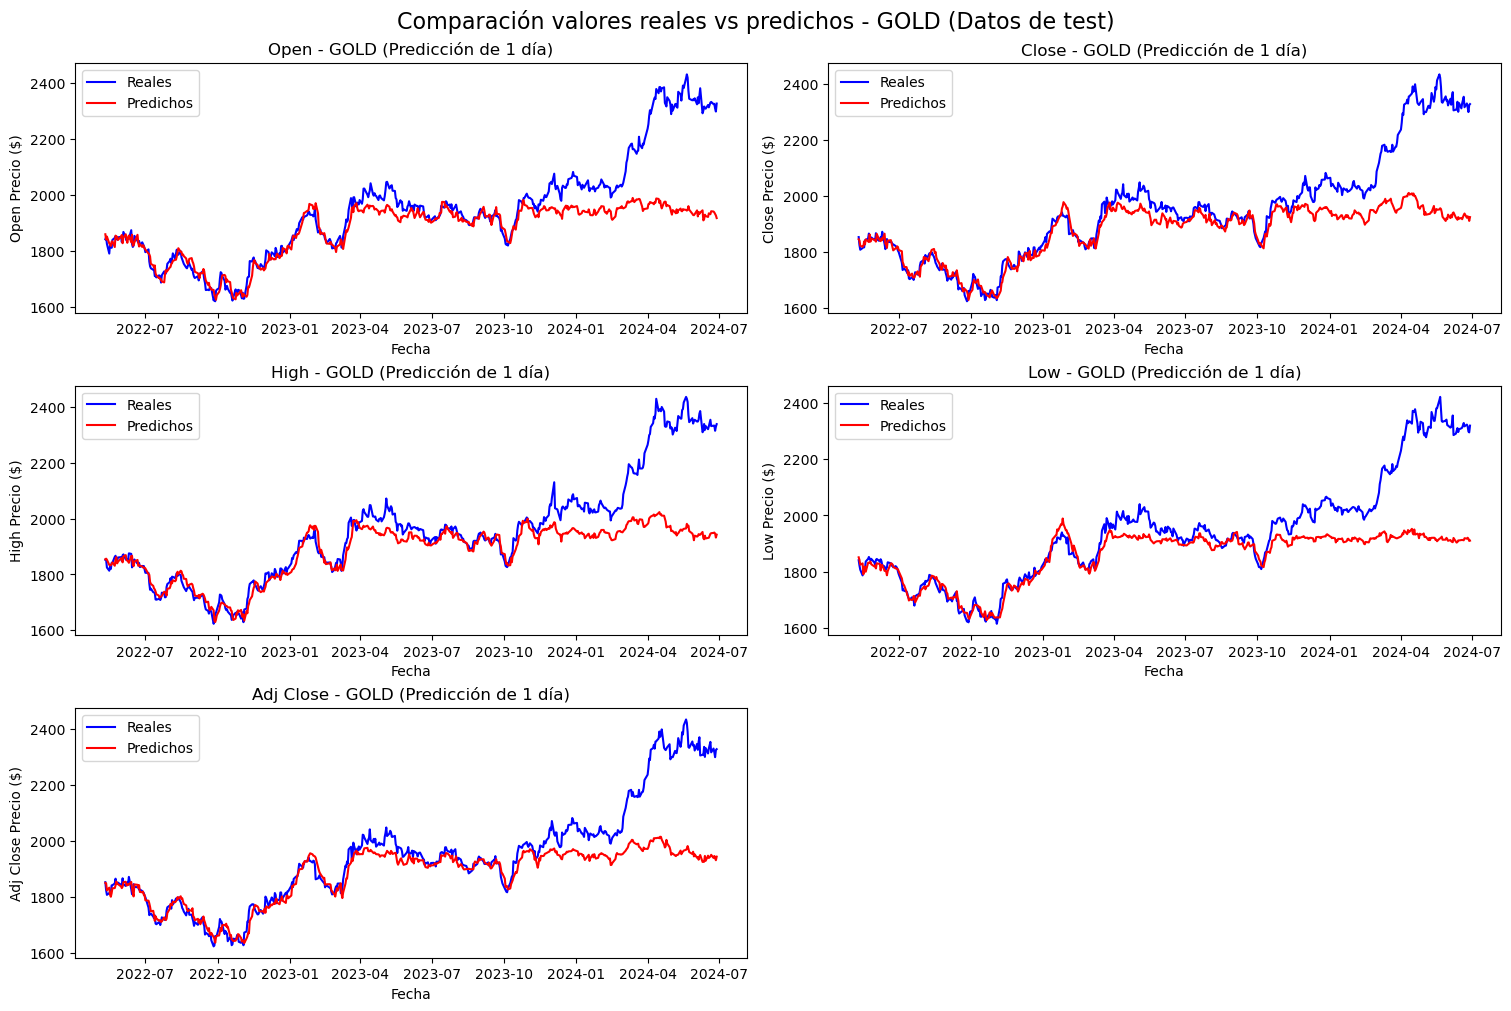

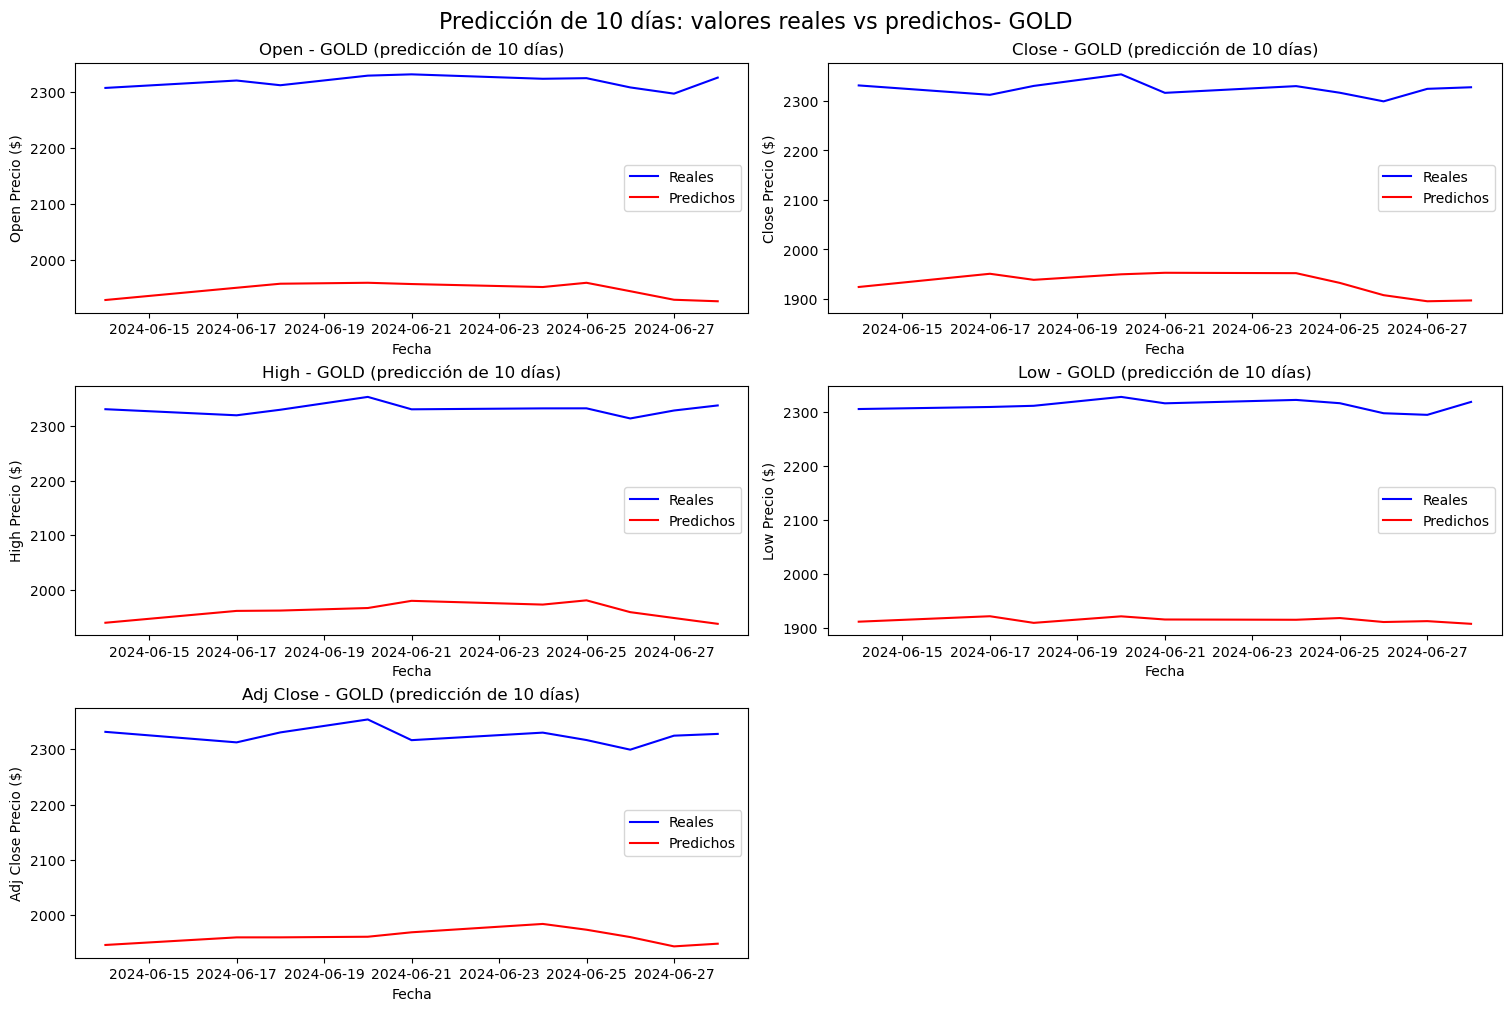

INFO:root:Predicting Open for BITCOIN...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 16224538.81233076, RMSE: 4027.969564474235, MAE: 2527.8461260895456, R^2: 0.9377821575433569

INFO:root:Gradient Boosting recursive forecasting - MSE: 37768649.57192319, RMSE: 6145.62035696342, MAE: 5799.491606411905, R^2: -11.030726179336353

INFO:root:Predicting Close for BITCOIN...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 15681400.414000528, RMSE: 3959.9747996673573, MAE: 2621.126794317578, R^2: 0.9399326607722904

INFO:root:Gradient Boosting recursive forecasting - MSE: 22327354.47138479, RMSE: 4725.183009300781, MAE: 4011.2702166254253, R^2: -7.247289301463438

INFO:root:Predicting High for BITCOIN...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 10932799.858902503, RMSE: 3306.478467932689, MAE: 2409.0228041452056, R^2: 0.9599551514058505

INFO:root:Gradient Boosting recursive forecasting - MSE: 7628634.931288269, RMSE: 2761.9983583065846, MAE: 2167.238960563175, R^2: -2.105798030152816

INFO:root:Predicting Low for BITCOIN...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 17830821.32708461, RMSE: 4222.655719696387, MAE: 2680.4122186900577, R^2: 0.927707879868373

INFO:root:Gradient Boosting recursive forecasting - MSE: 43669578.89587328, RMSE: 6608.296217322078, MAE: 6096.450599367785, R^2: -10.888387124288814

INFO:root:Predicting Adj Close for BITCOIN...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 13556344.691373358, RMSE: 3681.8941716694353, MAE: 2551.1967649766743, R^2: 0.9480726507986191

INFO:root:Gradient Boosting recursive forecasting - MSE: 15058380.435359374, RMSE: 3880.5129087994765, MAE: 3108.543067236419, R^2: -4.562272056058916



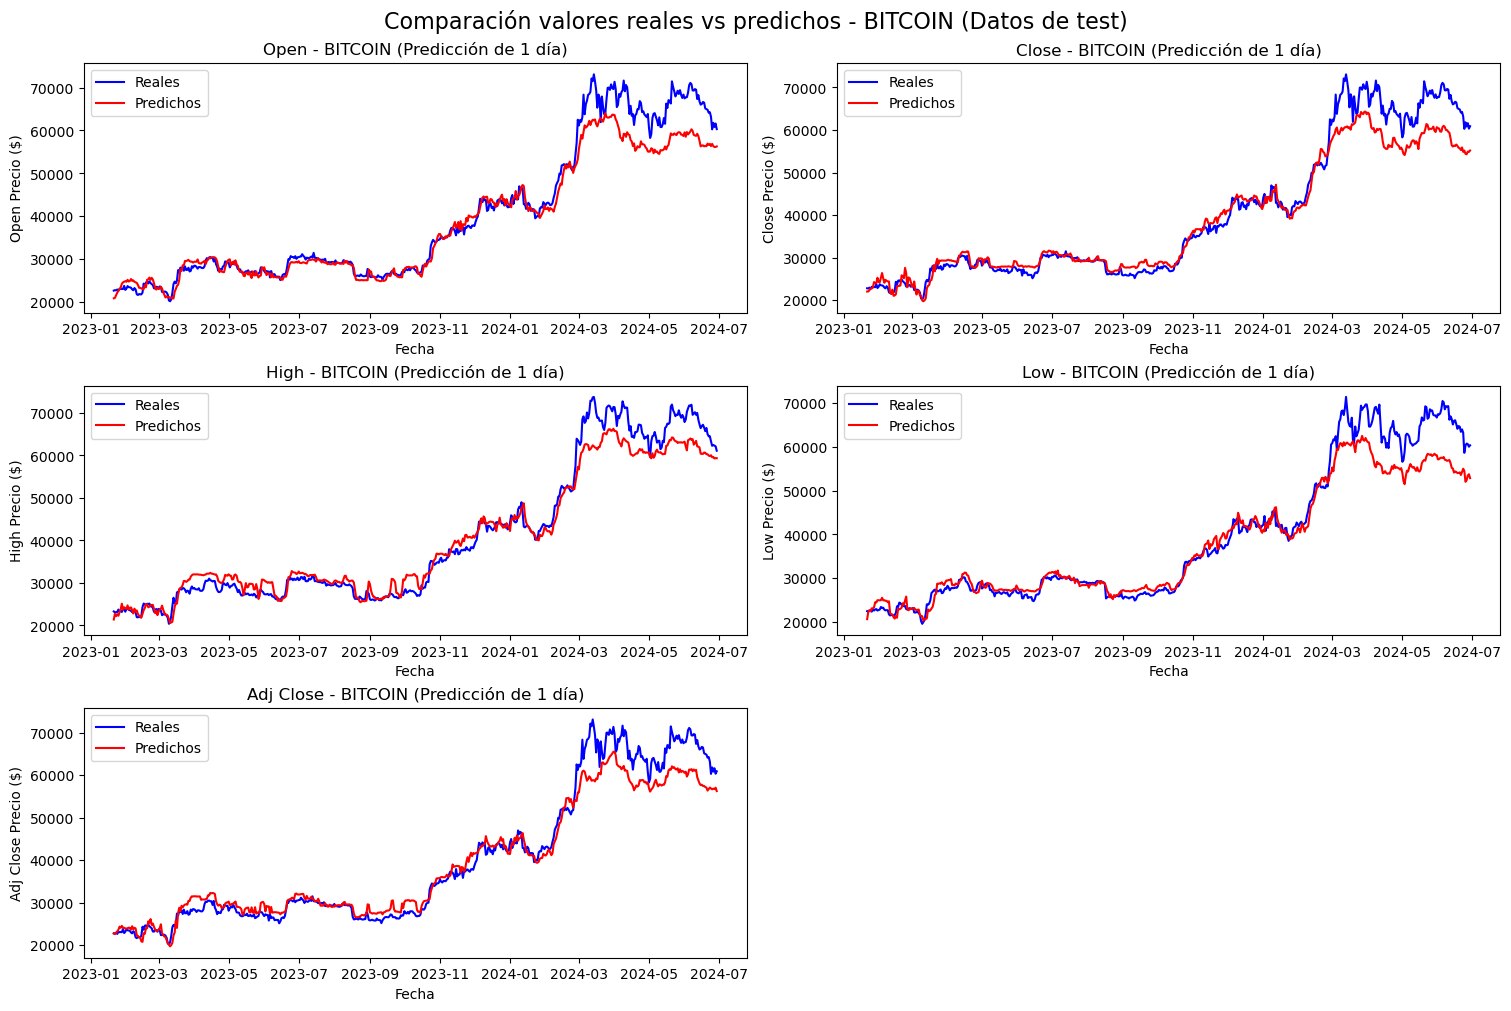

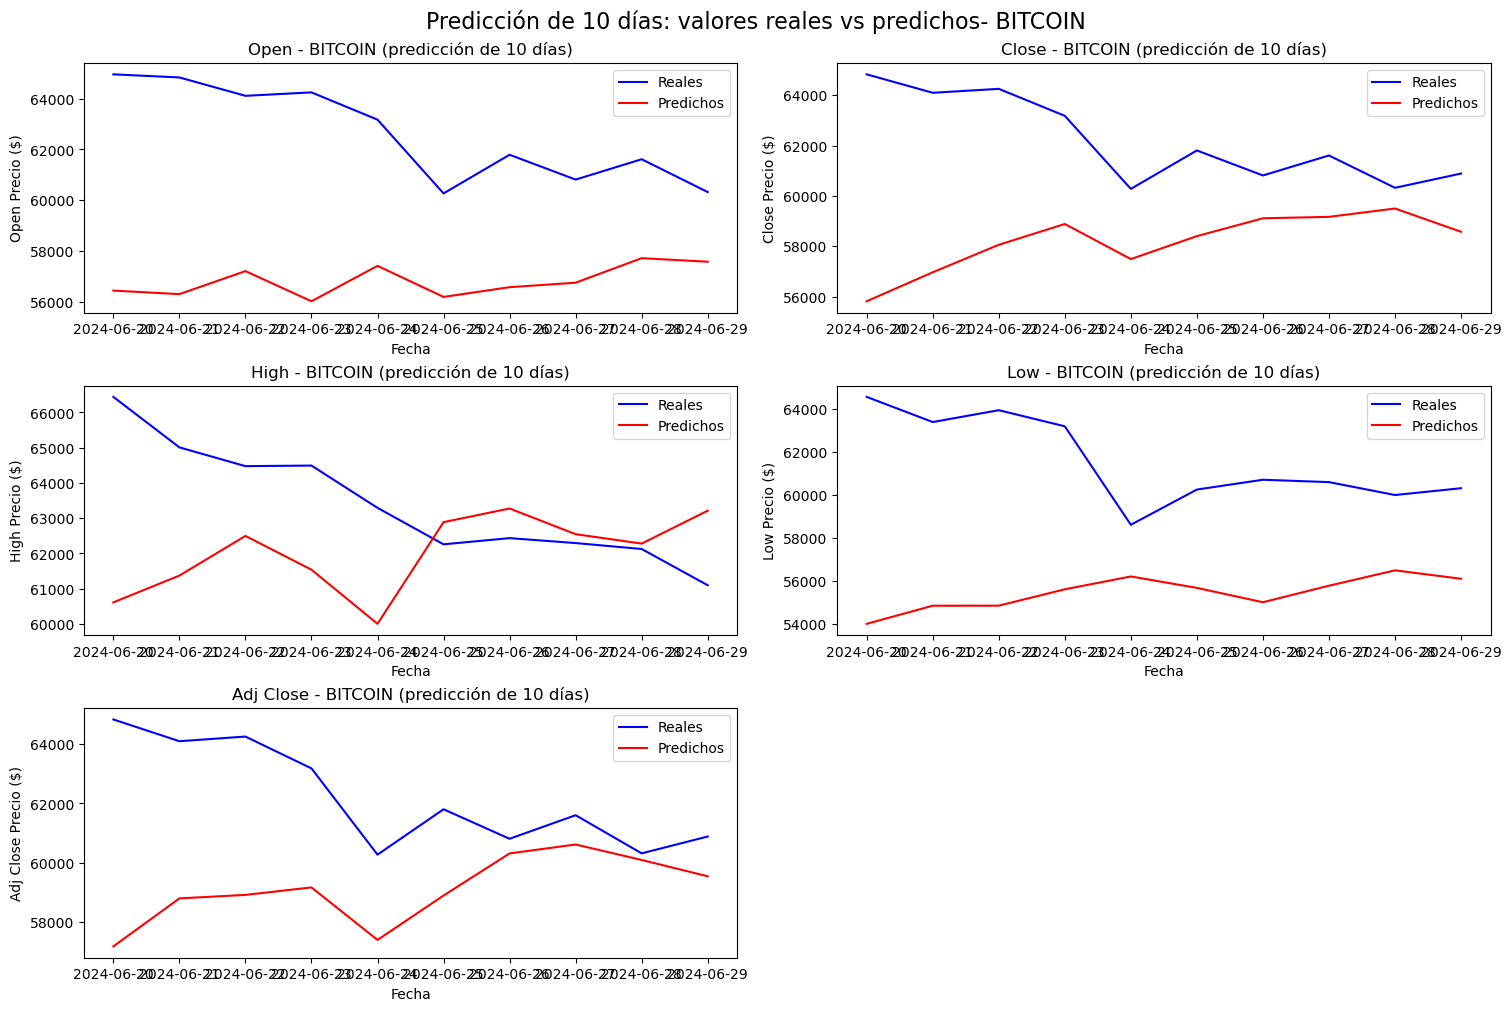

INFO:root:Predicting Open for NVIDIA...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 889.2057029350482, RMSE: 29.81955235973619, MAE: 17.971275548305474, R^2: -0.04106014784341361

INFO:root:Gradient Boosting recursive forecasting - MSE: 9315.989284176783, RMSE: 96.51937258486912, MAE: 96.38710477400228, R^2: -334.21598447286857

INFO:root:Predicting Close for NVIDIA...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 903.2235668204451, RMSE: 30.05367809138251, MAE: 18.183603479144743, R^2: -0.05900763704273482

INFO:root:Gradient Boosting recursive forecasting - MSE: 9243.545820557885, RMSE: 96.14336077211928, MAE: 96.028829657919, R^2: -405.38151884533966

INFO:root:Predicting High for NVIDIA...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 980.5167446898852, RMSE: 31.313203999110108, MAE: 19.01995410663135, R^2: -0.10912226674546566

INFO:root:Gradient Boosting recursive forecasting - MSE: 10076.877424061135, RMSE: 100.38365117916928, MAE: 100.27226023863295, R^2: -423.79043590629794

INFO:root:Predicting Low for NVIDIA...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 893.0333134543904, RMSE: 29.883662985892315, MAE: 18.09474416934431, R^2: -0.09220067945697408

INFO:root:Gradient Boosting recursive forecasting - MSE: 8936.535500247872, RMSE: 94.53325076526181, MAE: 94.44394879539843, R^2: -493.37535261768795

INFO:root:Predicting Adj Close for NVIDIA...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


INFO:root:Gradient Boosting - MSE: 912.1184035042512, RMSE: 30.201298043366467, MAE: 18.088720116629432, R^2: -0.0692349879440215

INFO:root:Gradient Boosting recursive forecasting - MSE: 9266.585348193847, RMSE: 96.26310481276742, MAE: 96.13893207186027, R^2: -406.3944243272769



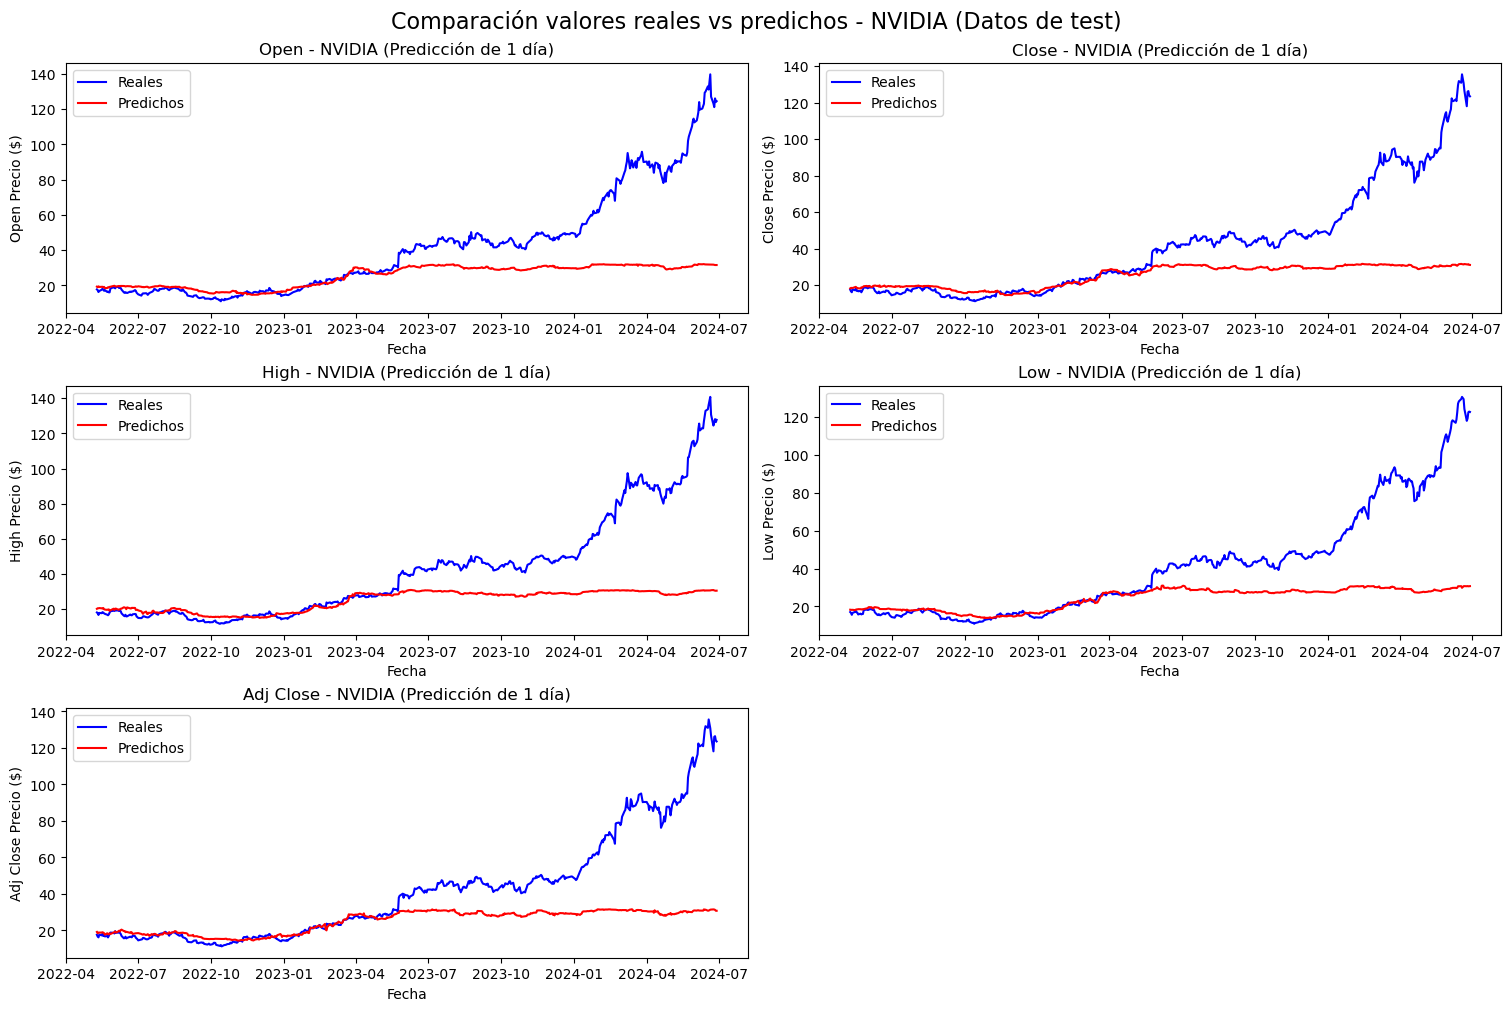

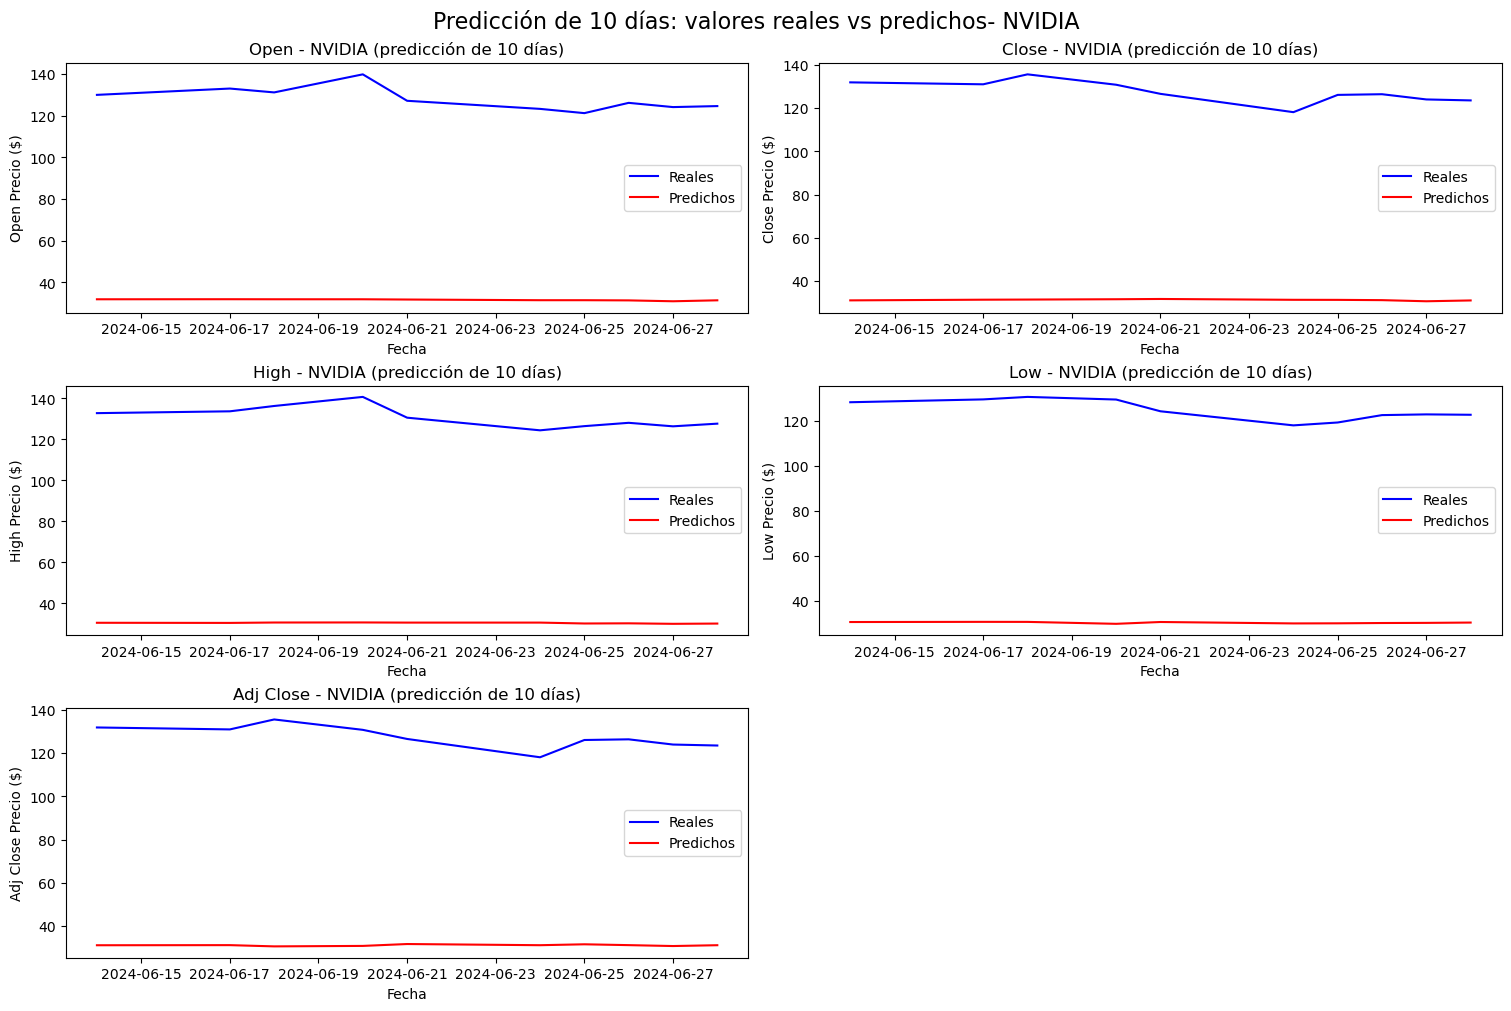

INFO:root:Summary of results:
INFO:root:    Company     Target                  model           MSE         RMSE  \
0     APPLE       Open       one-day forecast  1.798880e+02    13.412234   
1     APPLE       Open  recursive_forecasting  1.728294e+03    41.572760   
2     APPLE      Close       one-day forecast  1.233503e+02    11.106318   
3     APPLE      Close  recursive_forecasting  1.320933e+03    36.344644   
4     APPLE       High       one-day forecast  2.083172e+02    14.433199   
5     APPLE       High  recursive_forecasting  1.957267e+03    44.241012   
6     APPLE        Low       one-day forecast  1.622701e+02    12.738527   
7     APPLE        Low  recursive_forecasting  1.565470e+03    39.566016   
8     APPLE  Adj Close       one-day forecast  1.789494e+02    13.377198   
9     APPLE  Adj Close  recursive_forecasting  1.727137e+03    41.558839   
10  S&P 500       Open       one-day forecast  8.697045e+04   294.907527   
11  S&P 500       Open  recursive_forecasting  7

In [21]:
# Main Execution
if __name__ == "__main__":
    # Load stock data and calculate financial indicators
    results = {}

    for company_name in CONFIG['company_names']:
        # Prepare subplots for the entire test set, last 30 days, and recursive forecast
        fig_entire, axes_entire = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), constrained_layout=True)
        fig_entire.suptitle(f'Comparación valores reales vs predichos - {company_name} (Datos de test)', fontsize=16)
        axes_entire = axes_entire.flatten()

        fig_recursive, axes_recursive = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), constrained_layout=True)
        fig_recursive.suptitle(f"Predicción de {CONFIG['forecast_horizon']} días: valores reales vs predichos- {company_name}", fontsize=16)
        axes_recursive = axes_recursive.flatten()

        for idx, target_column in enumerate(['Open', 'Close', 'High', 'Low', 'Adj Close']):
            logging.info(f"Predicting {target_column} for {company_name}...\n")

            # Prepare data for the company and target column
            stock_data = prepare_data_for_modeling(main_df, company_name, target_column, CONFIG['mode'], CONFIG['specific_indicators'])
            X, y, dates = create_ML_dataset(stock_data, CONFIG['lookback'], target_column, CONFIG['mode'])
            X = X.reshape(X.shape[0], -1)

            # Split the data into training and testing sets (85/15 split)
            train_size = int(0.85 * len(X))
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]
            dates_train, dates_test = dates[:train_size], dates[train_size:]

            # Scale the data
            scaler_X = MinMaxScaler()
            X_train_scaled = scaler_X.fit_transform(X_train)
            X_test_scaled = scaler_X.transform(X_test)

            scaler_y = MinMaxScaler()
            y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
            y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

            # Get model and parameters
            model, param_grid = get_model_and_params(CONFIG['model_choice'])

            # Fit model
            best_model, best_params = fit_model(X_train_scaled, y_train_scaled, model, param_grid, CONFIG['use_randomized_search'])
            y_pred_scaled = best_model.predict(X_test_scaled)
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

            # Compute evaluation metrics
            mse = mean_squared_error(y_test_rescaled, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test_rescaled, y_pred)
            r2 = r2_score(y_test_rescaled, y_pred)

            logging.info(f"{CONFIG['model_choice']} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}\n")

            # Store the results
            results[(company_name, target_column,'one-day forecast')] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R^2': r2,
                'Best Params': best_params
            }

            # Plot results for the entire test set
            plot_results_subplots(dates_test, y_test_rescaled, y_pred, target_column, company_name, 'Predicción de 1 día', axes_entire.flatten()[idx])

            # Perform and plot recursive forecasting
            mse,rmse,mae,r2 = recursive_forecasting_multi_feature_corrected(
                X_test_scaled, scaler_y, best_model, CONFIG['lookback'], CONFIG['forecast_horizon'],
                y_test_rescaled, dates_test, target_column, company_name, axes_recursive.flatten()[idx]
            )
            logging.info(f"{CONFIG['model_choice']} recursive forecasting - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}\n")
            results[(company_name, target_column,'recursive_forecasting')] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R^2': r2,
                'Best Params': best_params
            }

        axes_entire[-1].axis('off')
        axes_recursive[-1].axis('off')
        plt.show(fig_entire)
        plt.show(fig_recursive)

    # Convert results to DataFrame for better visualization

    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.index.names = ['Company', 'Target','model']
    results_df.reset_index(inplace=True)

    logging.info("Summary of results:")
    logging.info(results_df)

In [22]:
results_df.to_csv('GradientBoosting_specific_indicators.csv')

### Predicciones con LSTM | Predictions with LSTM

Funciones para la predicción recursiva y el ajuste de hiperparámetros | Recursive forecasting and fine-tuning functions

In [31]:
# Function to recursively forecast future prices for n days using a multi-feature LSTM model
def recursive_forecast_lstm(model, initial_data, n_steps, n_features):
    predictions = []
    current_input = initial_data[-CONFIG['lookback']:]  # Start with the last lookback window from the input data

    for _ in range(n_steps):
        # Ensure the current input remains scaled for the LSTM model (since model was trained on scaled data)
        current_input_scaled = current_input.reshape((1, CONFIG['lookback'], n_features))  # Reshape for LSTM input

        # Predict the next values for all features (still scaled)
        next_prediction = model.predict(current_input_scaled).flatten()  # Predict the next value for all features

        predictions.append(next_prediction)  # Append the scaled predictions for this step

        # Update the input for the next prediction: drop the first row and append the new prediction
        next_input = np.vstack([current_input[1:], next_prediction])
        current_input = next_input  # The new input is the combination of previous input + new prediction

    return np.array(predictions)

def build_lstm_model(hp, n_features):
    model = Sequential()

    # Primera capa LSTM con un rango más conservador para lstm_units_1
    lstm_units_1 = hp.Choice('lstm_units_1', values=[32, 64, 128, 256])  # Rango ajustado
    model.add(LSTM(units=lstm_units_1, activation='relu', return_sequences=True,
                   kernel_regularizer=l2(1e-4), input_shape=(CONFIG['lookback'], n_features)))

    # Añadir Batch Normalization para estabilizar el entrenamiento
    model.add(BatchNormalization())

    # Capa de Dropout con un rango moderado de valores
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)  # Rango moderado
    model.add(Dropout(dropout_rate))

    # Segunda capa LSTM con un rango ajustado de unidades
    lstm_units_2 = hp.Choice('lstm_units_2', values=[32, 64, 128])  # Valores más pequeños
    model.add(LSTM(units=lstm_units_2, activation='relu', kernel_regularizer=l2(1e-4)))

    # Capa final densa para predecir todas las características
    model.add(Dense(n_features))

    # Ajuste de la tasa de aprendizaje (learning_rate)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')  # Tasa conservadora

    # Optimizador Adam con clipping para evitar explosión de gradientes
    opt = Adam(learning_rate=learning_rate, clipnorm=1.0)

    # Compilar el modelo
    model.compile(optimizer=opt, loss='mse')

    return model

Ejecucción principal para predicción con LSTM | Main execution for LSTM prediction

Trial 1 Complete [00h 00m 18s]
val_loss: 0.04328567907214165

Best val_loss So Far: 0.04328567907214165
Total elapsed time: 00h 00m 18s


Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0262 - val_loss: 0.5386 - learning_rate: 3.6411e-04
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0121 - val_loss: 0.4812 - learning_rate: 3.6411e-04
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0101 - val_loss: 0.2942 - learning_rate: 3.6411e-04
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0063 - val_loss: 0.1718 - learning_rate: 3.6411e-04
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0051 - val_loss: 0.0340 - learning_rate: 3.6411e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


INFO:root:Single-target LSTM - MSE: 887.2158493424473, RMSE: 29.78616875904733, MAE: 28.879187994736892, R^2: -1.1858970229309151



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


INFO:root:Recursive LSTM - MSE: 2238.6679599220633, RMSE: 47.3145639303805, MAE: 46.91813507080078, R^2: -270.6105475802295



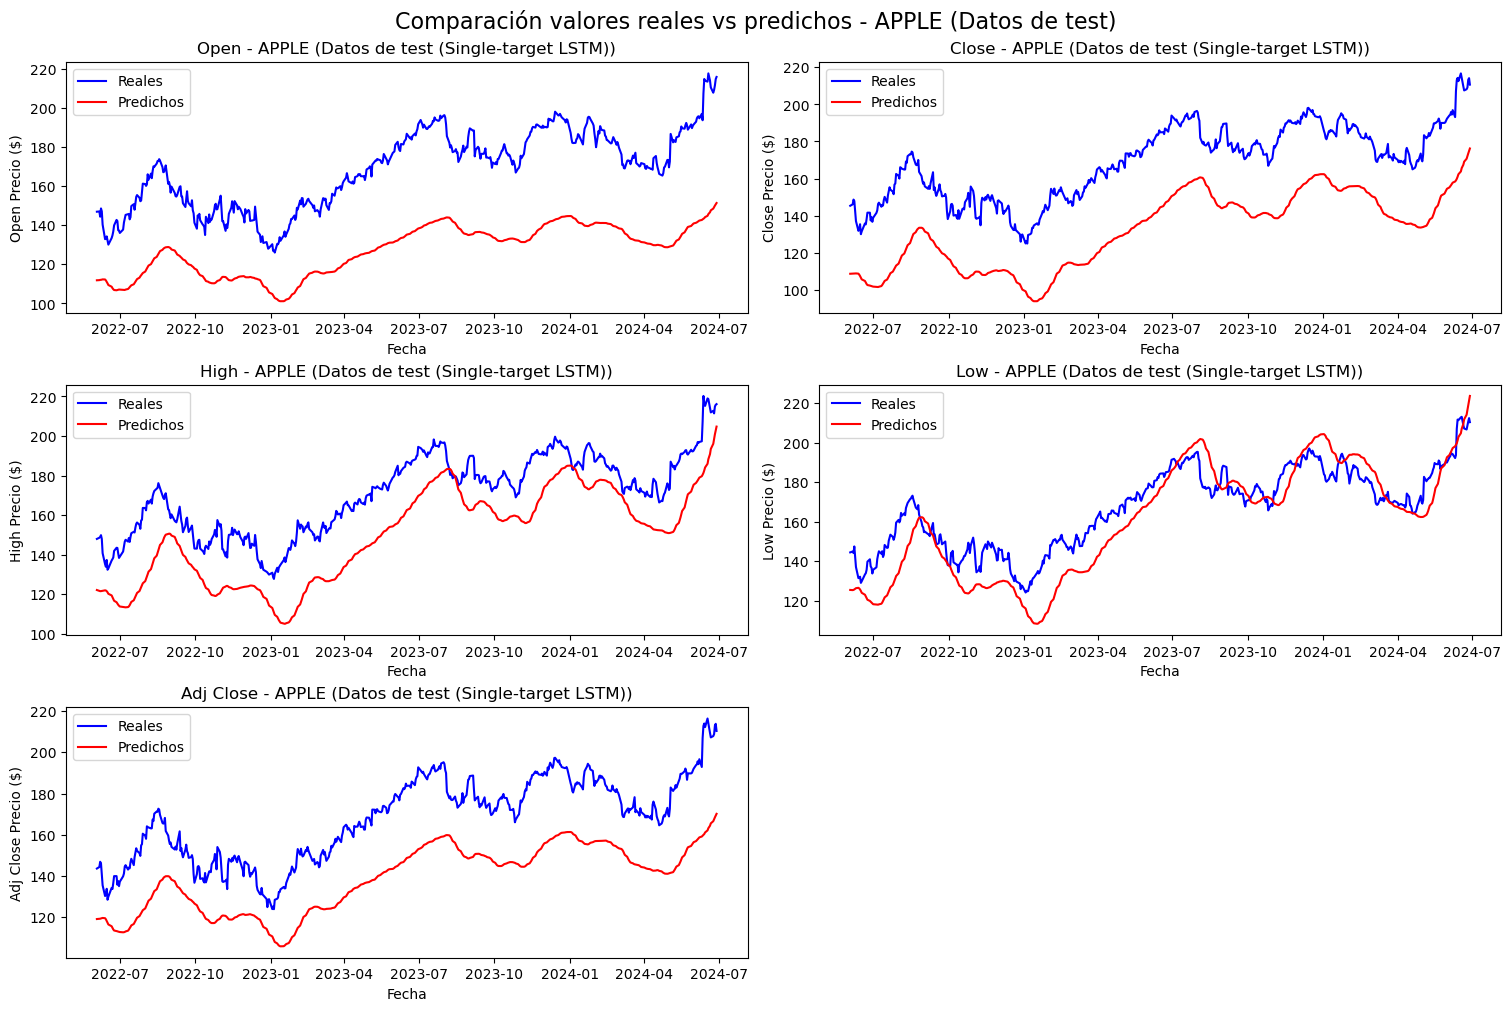

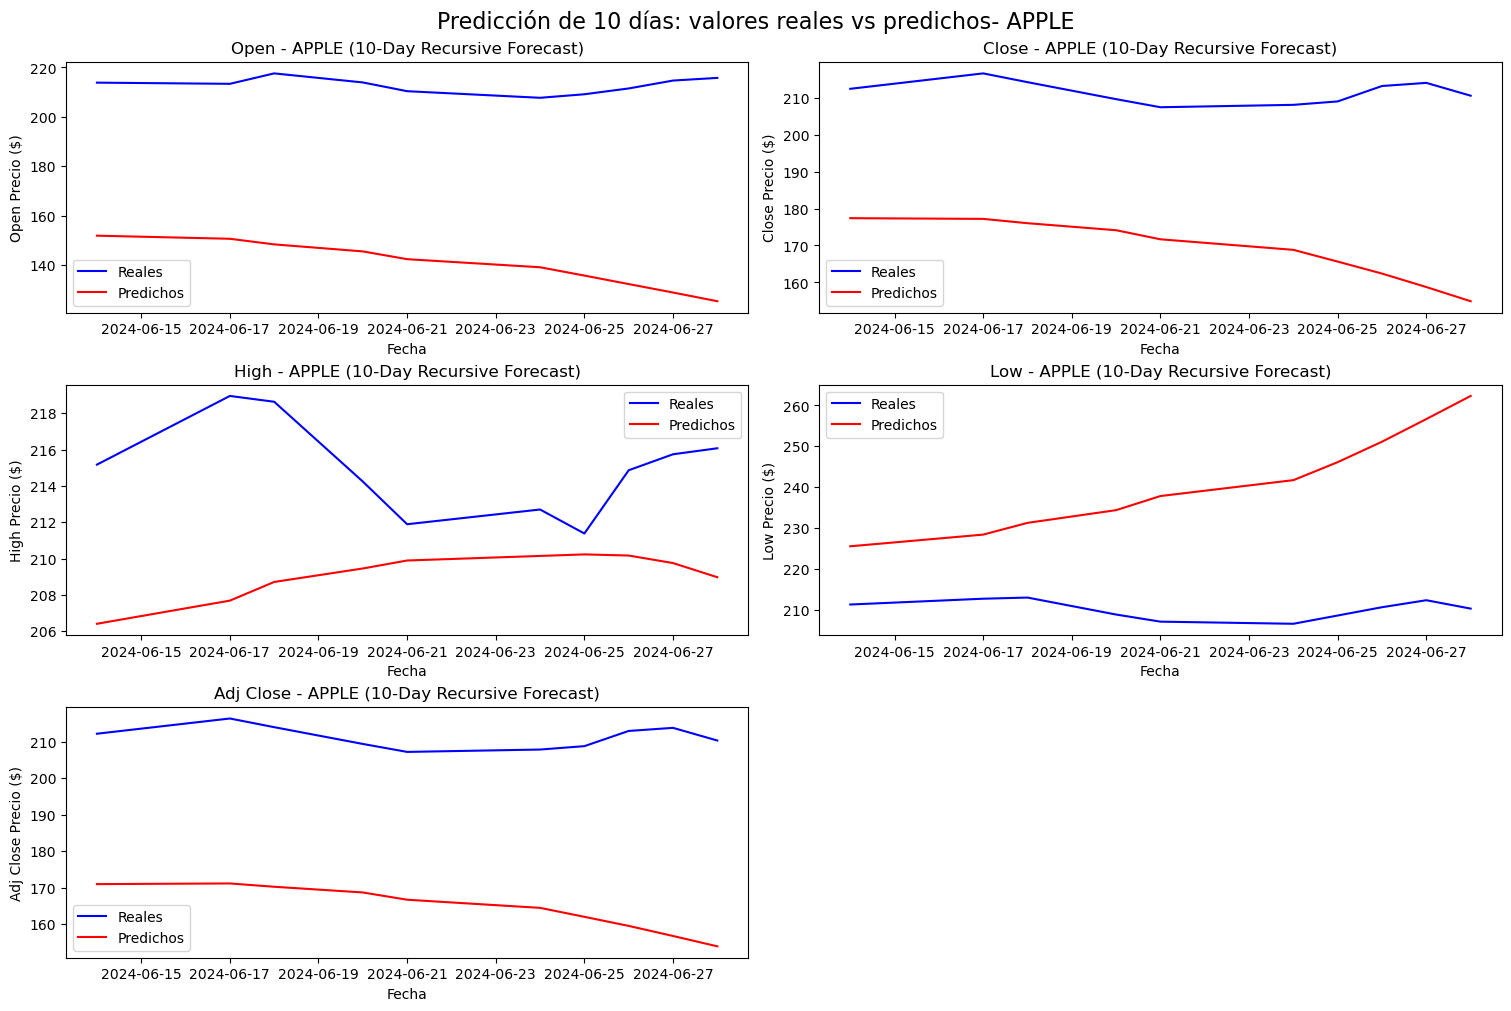

INFO:root:Predicting Open for S&P 500...

/Users/jesus.ortiz-perez/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(540, 1)

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |lstm_units_1
0.2               |0.2               |dropout_rate
32                |32                |lstm_units_2
0.00039544        |0.00039544        |learning_rate

Epoch 1/10
13/95 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1232

/Users/jesus.ortiz-perez/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0491 - val_loss: 0.5108
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0112 - val_loss: 0.4633
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0085 - val_loss: 0.3181
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0068 - val_loss: 0.2032
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059 - val_loss: 0.0527
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0065 - val_loss: 0.0100
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0049 - val_loss: 0.0416
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - val_loss: 0.0895
Epoch 10/10
49/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0040

KeyboardInterrupt: 

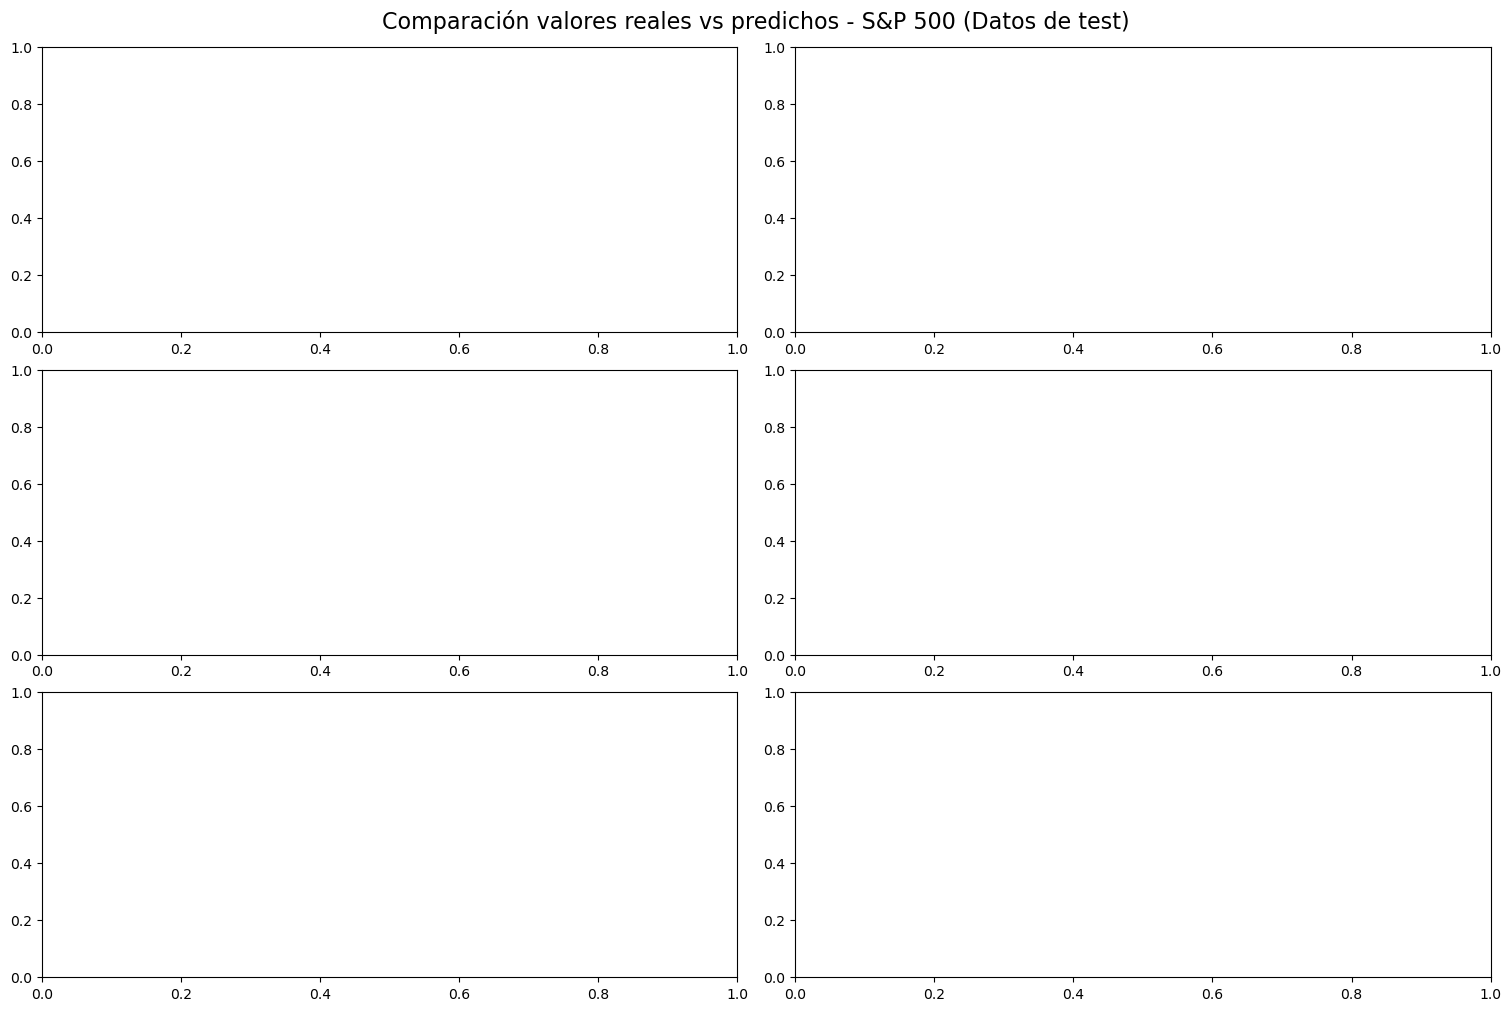

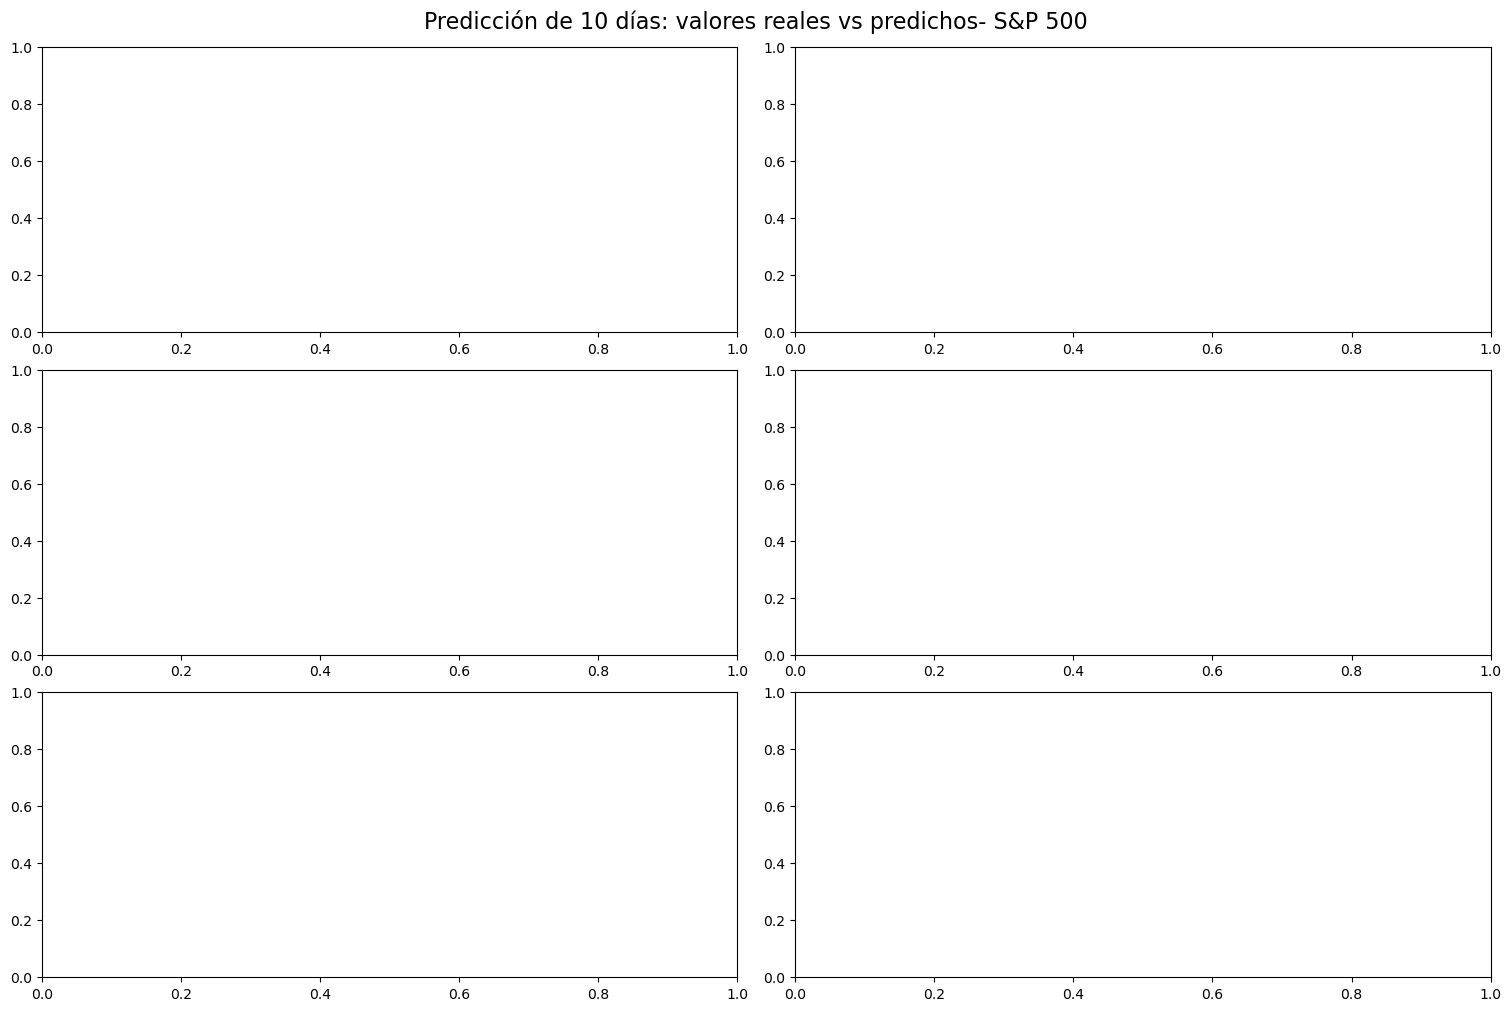

In [ ]:
results = {}
for company_name in CONFIG['company_names']:
    # Prepare subplots for the entire test set and recursive forecast
    fig_entire, axes_entire = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), constrained_layout=True)
    fig_entire.suptitle(f'Comparación valores reales vs predichos - {company_name} (Datos de test)', fontsize=16)
    axes_entire = axes_entire.flatten()

    fig_recursive, axes_recursive = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), constrained_layout=True)
    fig_recursive.suptitle(f"Predicción de {CONFIG['forecast_horizon']} días: valores reales vs predichos- {company_name}", fontsize=16)
    axes_recursive = axes_recursive.flatten()

    for idx, target_column in enumerate(['Open', 'Close', 'High', 'Low', 'Adj Close']):
        logging.info(f"Predicting {target_column} for {company_name}...\n")

        # Prepare data for the company and target column based on mode
        stock_data = prepare_data_for_modeling(main_df, company_name, target_column, CONFIG['mode'], CONFIG['specific_indicators'])

        # Determine features based on mode
        # Ensure the target column is used as a feature
        if CONFIG['mode'] == 'without_indicators':
            features = [target_column]  # Only the target column is used as input
        elif CONFIG['mode'] == 'specific_indicators':
            features = [f"{target_column}_{indicator}" for indicator in CONFIG['specific_indicators'] if f"{target_column}_{indicator}" in stock_data.columns]
            features.append(target_column)  # Ensure the target column is included
        elif CONFIG['mode'] == 'all_indicators':
            features = [col for col in stock_data.columns if col.startswith(target_column)]
            if target_column not in features:
                features.append(target_column)  # Ensure the target column is included
        elif CONFIG['mode'] == 'core_values':
            core_columns = ['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume']
            features = [col for col in core_columns if col != target_column and col in stock_data.columns]
            features.append(target_column)  # Ensure the target column is included
        else:
            raise ValueError("Invalid mode selected. Choose from 'without_indicators', 'specific_indicators', 'all_indicators', 'core_values'.")

        selected_data = stock_data[features]
        train_size = int(0.85 * len(selected_data))
        X_train, X_test = selected_data[:train_size], selected_data[train_size:]
        y_train, y_test = stock_data[target_column][:train_size], stock_data[target_column][train_size:]

        n_features = selected_data.shape[1]

        # Scale input features and target
        scaler_X = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        print(X_test_scaled.shape)

        scaler_y = MinMaxScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

        # Create TimeSeries Generator
        train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=CONFIG['lookback'], batch_size=32)
        test_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=CONFIG['lookback'], batch_size=32)

        # Initialize tuner within the loop and pass n_features
        tuner = RandomSearch(
            lambda hp: build_lstm_model(hp, n_features),
            objective='val_loss',
            max_trials=1,
            executions_per_trial=1,
            directory=f'lstm_tuning_{company_name}_{target_column}',
            project_name=f'lstm_hyperparam_tuning_{company_name}_{target_column}'
        )

        # Perform hyperparameter tuning
        tuner.search(train_generator, epochs=10, validation_data=test_generator, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], verbose=1)

        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)

        # Callbacks: EarlyStopping and ReduceLROnPlateau for dynamic learning rate adjustment
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

        # Train the model with the best hyperparameters
        model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[early_stopping, reduce_lr])

        # Generate predictions
        test_predictions = model.predict(test_generator)
        target_index = list(stock_data.columns).index(target_column)
        target_predictions = test_predictions[:, target_index]

        target_predictions_rescaled = scaler_y.inverse_transform(target_predictions.reshape(-1, 1)).flatten()
        pred_length = len(target_predictions_rescaled)

        y_test_actual = scaler_y.inverse_transform(y_test_scaled[CONFIG['lookback']:])[:pred_length].flatten()

        mse = mean_squared_error(y_test_actual, target_predictions_rescaled)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_actual, target_predictions_rescaled)
        r2 = r2_score(y_test_actual, target_predictions_rescaled)

        logging.info(f"Single-target LSTM - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}\n")

        # Store results and hyperparameters
        results[(company_name, target_column, 'Single-target LSTM')] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R^2': r2,
            'Hyperparameters': {
                'LSTM Units 1': best_hps.get('lstm_units_1'),
                'LSTM Units 2': best_hps.get('lstm_units_2'),
                'Dropout Rate': best_hps.get('dropout_rate'),
                'Learning Rate': best_hps.get('learning_rate')
            }
        }

        dates_test = X_test.index[CONFIG['lookback']:]
        plot_results_subplots(dates_test[:pred_length], y_test_actual, target_predictions_rescaled, target_column, company_name, 'Predicción de 1 día', axes_entire[idx])

        # Start the recursive forecast for the future 'forecast_horizon' days
        initial_input = X_test_scaled[-(CONFIG['lookback']+CONFIG['forecast_horizon']):]  # Use the last 'lookback' window from the test set

        # Perform recursive forecasting for n future steps
        recursive_predictions_all_features = recursive_forecast_lstm(
            model, initial_input, CONFIG['forecast_horizon'], n_features
        )

        # Extract the target column's index from the dataset (assuming target_column exists in stock_data.columns)
        target_index = list(stock_data.columns).index(target_column)  # Find the index of the target column

        # Extract the target column from the multi-feature predictions (shape is (forecast_horizon, n_features))
        recursive_predictions_target = recursive_predictions_all_features[:, target_index]

        # Rescale the target column's recursive predictions back to the original scale
        recursive_predictions_rescaled = scaler_y.inverse_transform(recursive_predictions_target.reshape(-1, 1)).flatten()

        # Rescale the actual test set values for comparison (only for the last 'forecast_horizon' days)
        y_test_actual_rescaled = scaler_y.inverse_transform(y_test_scaled[-CONFIG['forecast_horizon']:]).flatten()

        # Ensure the test dates also correspond to the forecast horizon
        dates_test = X_test.index[-CONFIG['forecast_horizon']:]

        # Check that y_test_actual_rescaled and recursive_predictions_rescaled have the same length
        assert len(y_test_actual_rescaled) == len(recursive_predictions_rescaled), "Lengths of actual and predicted values don't match."

        # Calculate evaluation metrics for the target column
        mse = mean_squared_error(y_test_actual_rescaled, recursive_predictions_rescaled)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_actual_rescaled, recursive_predictions_rescaled)
        r2 = r2_score(y_test_actual_rescaled, recursive_predictions_rescaled)

        logging.info(f"Recursive LSTM - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}\n")

        # Store the results for evaluation
        results[(company_name, target_column, 'Recursive LSTM')] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R^2': r2,
        }

        # Plot the target column predictions vs actuals for the last forecasted horizon
        ax = axes_recursive[idx]
        plot_results_subplots(dates_test, y_test_actual_rescaled, recursive_predictions_rescaled, target_column, company_name, 'Predicción de 10 días', ax)

    # Hide the last (empty) subplot
    axes_entire[-1].axis('off')
    axes_recursive[-1].axis('off')
    plt.show(fig_entire)
    plt.show(fig_recursive)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index.names = ['Company', 'Target', 'Model']
results_df.reset_index(inplace=True)

logging.info("Summary of results:")
logging.info(results_df)